# Milestone Project I: Fantasy Football Analysis
## Tristan Morgan and David Brand

#### List of Requirements:
https://umich.instructure.com/courses/823467/pages/reading-team-project-guidelines?module_item_id=4900067

1. Problem formulation
2. Team formation
3. Selection of data sources
4. Project proposal creation
5. Faculty mentor assigned (by the teaching team)
6. Peer feedback on project proposals
7. Final project report + code
8. Peer feedback on project reports

#### Oral Exam 
Scheduled by each particpant seperately. Will go over questions about the project.



# Fantasy Football Analysis: Optimizing Draft and Injury Decisions

## Executive Summary

This project analyzes fantasy football data to identify the most meaningful elements for making optimized decisions. We examine four key areas:

1. **Draft Value Analysis**: Using autodrafted teams as a baseline, we quantify the value of human draft decisions and identify optimal draft strategies.
2. **Injury Impact Analysis**: We measure how injuries affect player performance by position, injury type, and status to inform start/sit decisions.
3. **Waiver Wire Baseline Analysis**: The baseline for Waiver Wire is 25 percentile of points added for all league-years combined.
4. **Start/Sit Baseline Analysis**: We use projected-optimal lineups as a baseline to measure the quality of weekly lineup decisions.

### Key Findings
**TODO Update all Key Findings**
- **Draft Advantage**: Human drafters show measurable advantages over autodraft in early rounds, with diminishing returns in later rounds.
- **Injury Impact**: Certain injury types (e.g., hamstring) have position-specific impacts that marginally affect point differentials.
- **Waiver Wire Value**: Waiver wire decisions contribute meaningful points throughout the season, with Q25 baseline providing minimal competency threshold.
- **Start/Sit Quality**: Managers generally make good lineup choices relative to projections, with start/sit decisions compounding weekly.
- **Cumulative Impact**: All three decision points (Draft, Waiver, Start/Sit) contribute meaningfully to overall team performance.
- **Decision Support**: Our analysis provides actionable insights for draft strategy, waiver wire management, and weekly lineup decisions.

### Data Sources

- **ESPN Fantasy Football API**: Historical league data (2021-2024) including drafts, lineups, and transactions
- **NFL Injury Database**: Player injury reports with type, status, and timing

---


# Initial Motivation

1.   The initial motivation is to analyze fantasy football data to determine the most meaningful elements for making optimized fantasy football decisions.
2.   We have a desire to do something relatively novel, but understand that this market is extremely saturated with similar projects.



# Data Sets Chosen

1.   Data 1 - ESPN Fantasy Football API
3.   Data 2 - Injury Database (nfl_data_py)



# Import Global Modules, Packages, or Objects

**Note:** Only need to run the block below if you do not have all of the required packages shown in the [README Prerequisites section](README.md#prerequisites).

In [1]:
# Install Required Packages
# Run this cell first to ensure all dependencies are installed

import subprocess
import sys

def install_package(package):
    """Install a package using pip."""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# List of required packages
required_packages = [
    "pandas",
    "numpy",
    "matplotlib",
    "seaborn",
    "scipy",
    "requests",
    "espn-api",
    "nfl-data-py"
]

print("Installing required packages...")
for package in required_packages:
    try:
        install_package(package)
        print(f"{package} installed/updated")
    except Exception as e:
        print(f"Failed to install {package}: {e}")

print("\nPackage installation complete!")
print("You can now proceed to the imports cell.")


Installing required packages...
pandas installed/updated
numpy installed/updated
matplotlib installed/updated
seaborn installed/updated
scipy installed/updated
requests installed/updated
espn-api installed/updated
nfl-data-py installed/updated

Package installation complete!
You can now proceed to the imports cell.


### Import Modules, Packages, and Objects

In [2]:
# Standard Library Imports
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import threading
from src.analysis.draft_value_analyzer import DraftValueAnalyzer
from src.analysis.injury_analyzer import InjuryAnalyzer
from src.data_fetchers.data_collector import collect_injury_data, collect_leagues_parallel

# Import Data

#### ESPN Fantasy Football Database via API

To pull any Fantasy Football data, you must first find a list of public leagues. To do this, we request access to league data by passing a league ID via the Fantasy Football API. To get a League ID, we generate random integers that are in a reasonable range for fantasy football league IDs and request data for them. The API returns a code that tells us if we were successful or not. Since that is quite inefficient, we find 5 accessible leagues and use their league ID's as a seed for a random generator. This improves our hit percentage drastically. We can now realistically get a list of League ID's for this project.

**Note:** You can continue working in other cells while this runs.

**Note:** This block of code takes a lot of time to run and has already been ran for you. Data is stored in data/raw/espn

In [3]:
# Initial Target League Discovery (Already Completed - Not Required)

# NOTE: The initial target league discovery has already been completed.
# The target leagues CSV file (data/raw/espn/targets_10team_ppr1_season_2024.csv) 
# already exists with 500+ leagues that match our criteria (10 teams, 1.0 PPR).
# 
# This code is provided for reference only. Uncomment and run ONLY if you need to 
# discover new target leagues from scratch.

# from src.data_fetchers.espn_random_public_league_fetcher_seeded_final_pull import harvest_target_leagues

# # Harvest target leagues (10 teams, 1.0 PPR)
# # This will find leagues matching our criteria and save them to:
# # data/raw/espn/targets_10team_ppr1_season_2024.csv
# target_leagues = harvest_target_leagues(
#     target_n=500,  # Number of target leagues to find
#     season=2024,
#     seeds_csv="data/raw/ESPN/seeds_200_season_2024.csv",
#     out_targets_csv="data/raw/espn/targets_10team_ppr1_season_2024.csv",
#     exists_401_csv="data/raw/ESPN/exists_401_season_2024.csv",
#     timeout=6.0,
#     rng_seed=None
# )

# print(f"\nFound {len(target_leagues)} target leagues")
# print("  These leagues will be used for data collection in the next step.")

In [4]:
# # Parallel Data Collection from ESPN Fantasy Football API
# def run_data_collection_background():
#     """Run data collection in background thread."""
#     print("Starting data collection in background...")

#     results = collect_leagues_parallel(
#         league_ids='data/raw/espn/targets_10team_ppr1_season_2024.csv',
#         years=range(2021, 2025),
#         max_workers=5,  
#         skip_existing=True,
#         verbose=False  
#     )
    
#     print(f"\n{'='*70}")
#     print(f"BACKGROUND DATA COLLECTION COMPLETE!")
#     print(f"{'='*70}")
#     print(f"Summary: {results['total_succeeded']} succeeded, {results['total_failed']} failed")
#     print(f"Total time: {results['total_time_minutes']:.1f} minutes ({results['total_time_minutes']/60:.2f} hours)")
#     print(f"{'='*70}")
    
    
#     global background_results
#     background_results = results
#     return results


# background_thread = threading.Thread(target=run_data_collection_background, daemon=True)
# background_thread.start()

# print("Data collection started in background thread")


#### Draft Value Analysis

Comprehensive analysis of draft value using autodrafted teams as a baseline. This includes:
1. **Data Cleaning**: Remove duplicates from raw data
2. **League Filtering**: Filter to standard leagues with consistent scoring rules
3. **Data Enrichment**: Add positions and season totals
4. **Optimal Lineup Computation**: Calculate optimal startable points
5. **Expected Value Calculation**: Compute expected values using multiple baselines
6. **Pick Scoring**: Score all picks against baselines


In [5]:
# Draft Value Analysis Pipeline
analyzer = DraftValueAnalyzer(
    raw_base="data/raw/espn",
    out_dir="data/preprocessed",
    years=range(2021, 2025),
    verbose=False
)


draft_with_valid = analyzer.run_full_pipeline(
    clean_data=True,           
    filter_standard=True,      
    filter_scoring=True,       
    filter_draft_length=True,  
    compute_optimal=True,      
    save_intermediate=True     
)

print(f"\nPipeline complete! Processed {len(draft_with_valid):,} draft picks")



Pipeline complete! Processed 53,440 draft picks


#### Compute Expected Values and Score Picks

Calculate expected values using multiple baselines and score all picks.


In [6]:
# Extract filtered lineups and optimal selections from the analyzer
# These were computed during the pipeline and stored as instance variables
lineups_filt = analyzer.lineups_filt
optimal_selected = analyzer.optimal_selected

if lineups_filt is None or optimal_selected is None:
    raise ValueError("Pipeline did not compute lineups_filt and optimal_selected. "
                     "Make sure run_full_pipeline was called with compute_optimal=True")

print(f"Extracted lineups_filt: {len(lineups_filt):,} records")
print(f"Extracted optimal_selected: {len(optimal_selected):,} records")

# Compute expected values using multiple baselines
expected_by_pick_year, expected_by_pick_pooled, expected_by_pick_poly = analyzer.compute_expected_values(
    estimator="trimmed_mean",  # Robust estimator
    trim=0.10,                 # Trim 10% from each tail
    smooth_window=5,           # Rolling window for smoothing
    poly_degree=4              # Polynomial degree
)

# Score all picks against baselines
draft_scored = analyzer.score_picks(
    expected_by_pick_year=expected_by_pick_year,
    expected_by_pick_pooled=expected_by_pick_pooled,
    expected_by_pick_poly=expected_by_pick_poly
)

# Save scored draft data
draft_scored_path = analyzer.out_dir / "draft_scored_all_baselines.csv"
draft_scored.to_csv(draft_scored_path, index=False)
print(f"\nSaved scored draft data to {draft_scored_path}")
print(f"  Total picks scored: {len(draft_scored):,}")

# Preview results
print("\nPreview of scored picks:")
print(draft_scored[[
    "League_ID", "Year", "Team", "Overall", "Player_norm",
    "Season_Total_Points_Valid",
    "Expected_Year", "Expected_Pooled_Denoised", "Expected_Poly",
    "Points_Added_Year", "Points_Added_Pooled", "Points_Added_Poly",
    "Z_Year", "Z_Pooled", "Z_Poly"
]].head(10))


Extracted lineups_filt: 890,589 records
Extracted optimal_selected: 890,589 records

Saved scored draft data to data\preprocessed\draft_scored_all_baselines.csv
  Total picks scored: 53,440

Preview of scored picks:
   League_ID  Year  Team  Overall          Player_norm  \
0     915297  2021     5        1          Dalvin Cook   
1     915297  2021     8        2  Christian McCaffrey   
2     915297  2021     2        3         Alvin Kamara   
3     915297  2021     1        4       Saquon Barkley   
4     915297  2021     9        5        Derrick Henry   
5     915297  2021     7        6        Davante Adams   
6     915297  2021    10        7      Ezekiel Elliott   
7     915297  2021     6        8          Tyreek Hill   
8     915297  2021     3        9         Travis Kelce   
9     915297  2021     4       10      Jonathan Taylor   

   Season_Total_Points_Valid  Expected_Year  Expected_Pooled_Denoised  \
0                      175.0     138.157143                191.682247   

#### Visualizations

Create visualizations to understand draft value patterns:
1. **Team Total Valid Points Distribution**: Compare autodrafted vs non-autodrafted teams
2. **Expected Value by Pick**: Show expected values with variance bands
3. **Human Advantage Analysis**: Compare human vs autodraft performance by year, round, and position


### Visualization Parameters Reference

All visualization methods support optional parameters for customization. 

For complete parameter documentation, see the [README.md](README.md#visualization-parameters-reference) file.

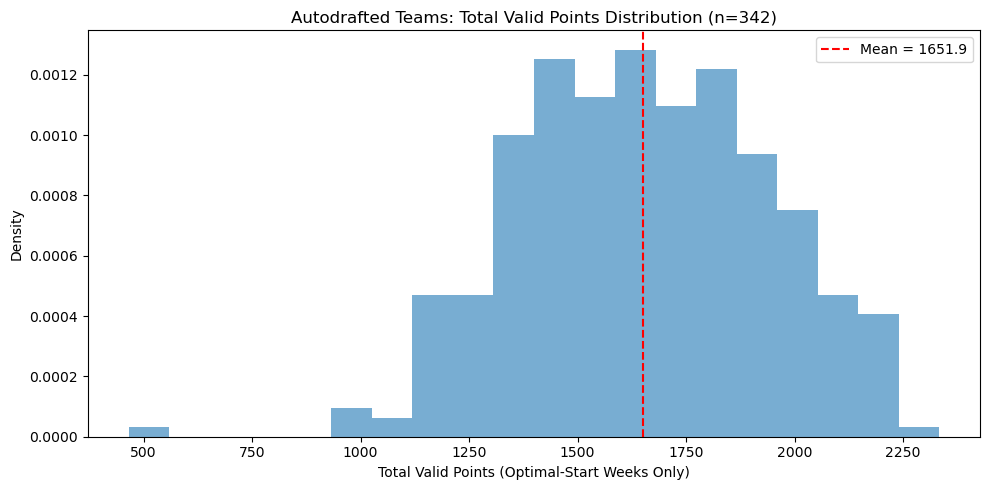

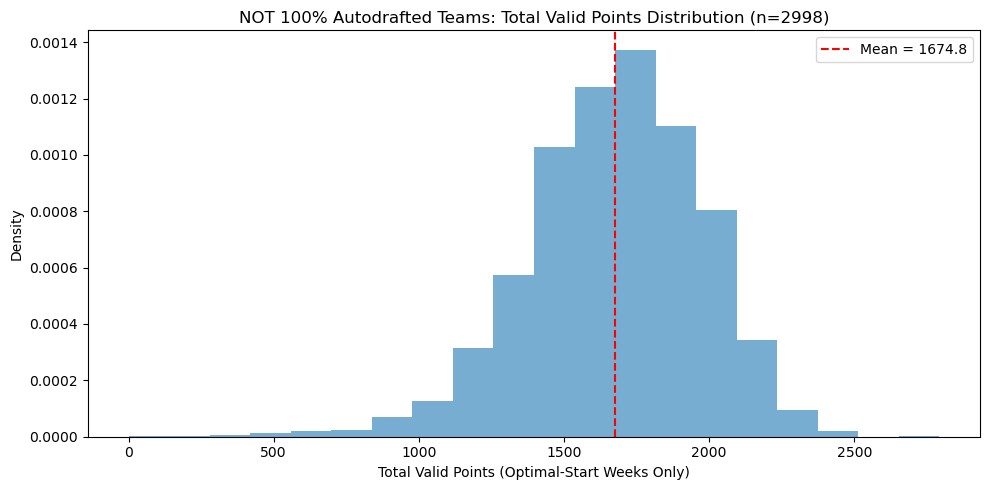

In [7]:
# Team Total Valid Points Distributions
# Compare autodrafted vs non-autodrafted teams

# Autodrafted teams
team_totals_auto = analyzer.plot_team_total_valid_points_distribution(
    fully_autodraft_only=True,
    bins=20
)

# Non-autodrafted teams
team_totals_non = analyzer.plot_team_total_valid_points_distribution(
    fully_autodraft_only=False,
    bins=20
)


### Observations: Team Total Valid Points Distribution

**Key Findings:**

- **Autodrafted Teams**: Show a more consistent distribution with less variance.
- **Non-Autodrafted Teams**: Display greater variance which would be expected from the variance in human decision making.
- **Performance Gap**: The distribution comparison reveals human drafters consistently outperform autodraft

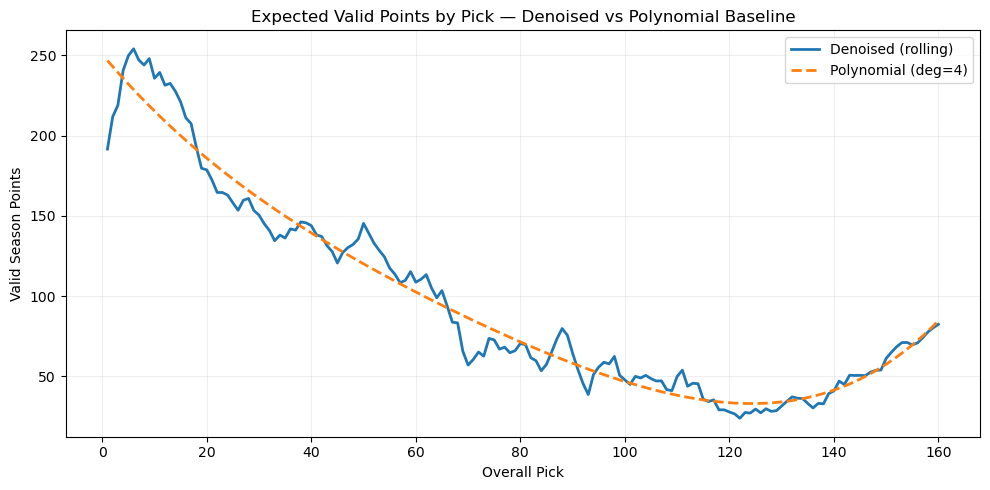

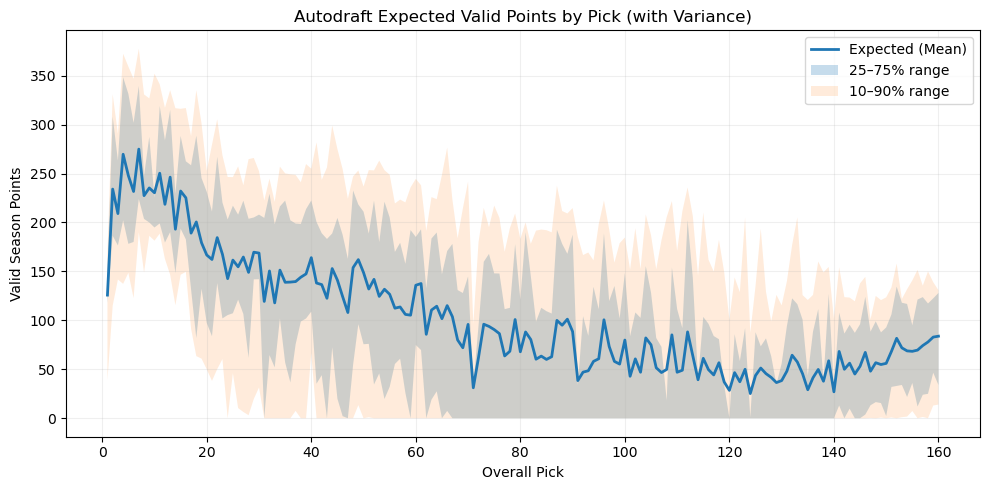

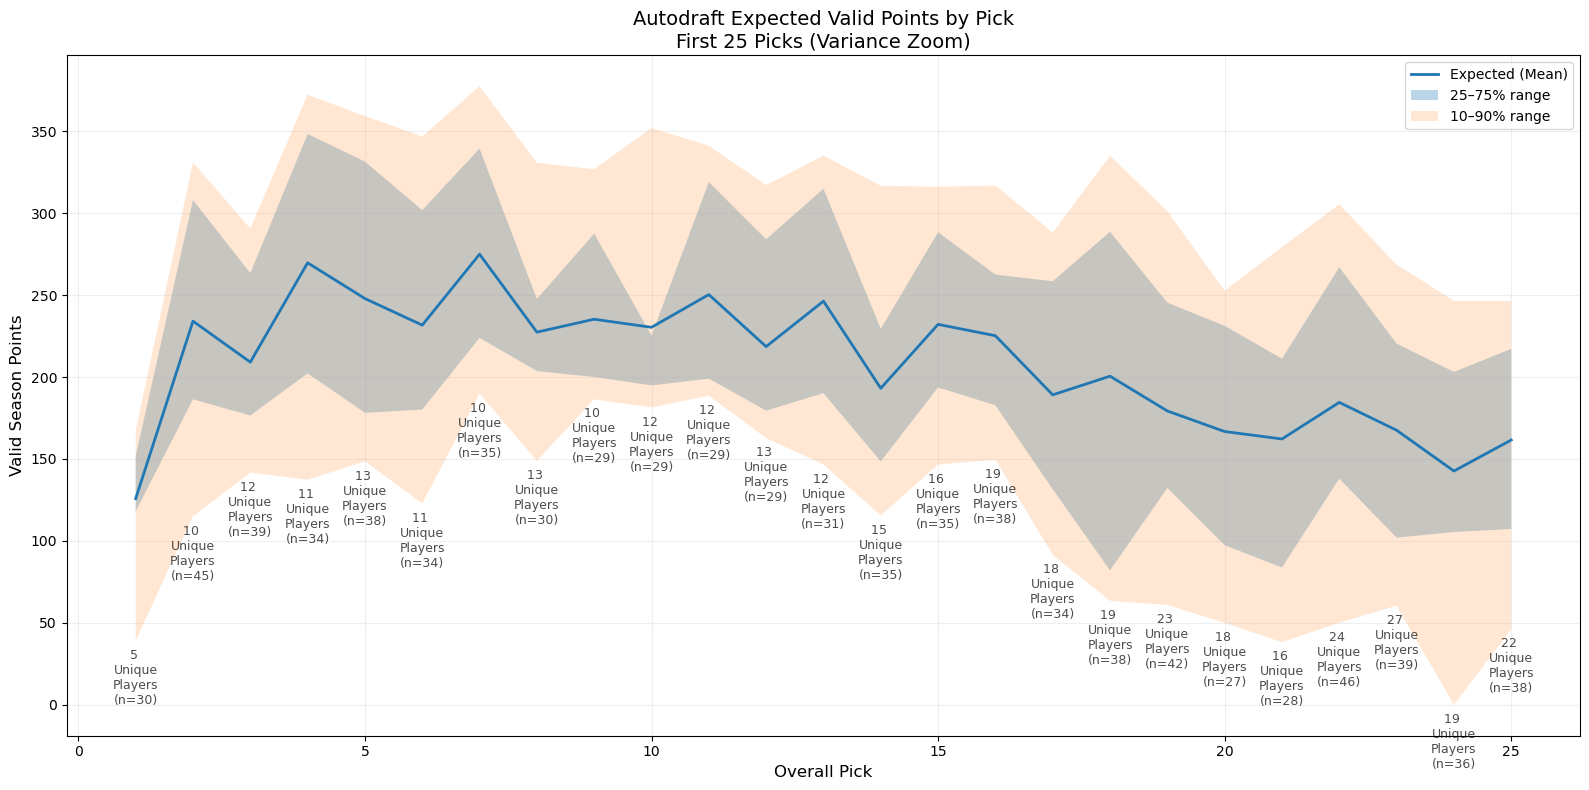

In [8]:
# Expected Value by Pick (with variance bands and polynomial fit)
analyzer.plot_expected_by_pick(
    expected_by_pick_pooled=expected_by_pick_pooled,
    expected_by_pick_poly=expected_by_pick_poly,
    show_variance=True,
    zoom_first_25=True  # Also show zoomed view of first 25 picks
)


### Observations: Expected Value by Pick

**Key Findings:**

- **Early Picks (1-25)**: Show highest expected values with significant variance, reflecting the premium placed on elite talent
- **Mid-Round Picks (26-100)**: Expected values decline gradually, with variance bands showing uncertainty in player evaluation
- **Late-Round Picks (100+)**: Expected values plateau, indicating diminishing returns and higher risk
- **Polynomial Fit**: Provides a smoothed expectation curve that accounts for non-linear draft value decay

**Strategic Insight**: The variance bands highlight that early picks have both higher upside and downside risk, while later picks are more predictable but offer less value.


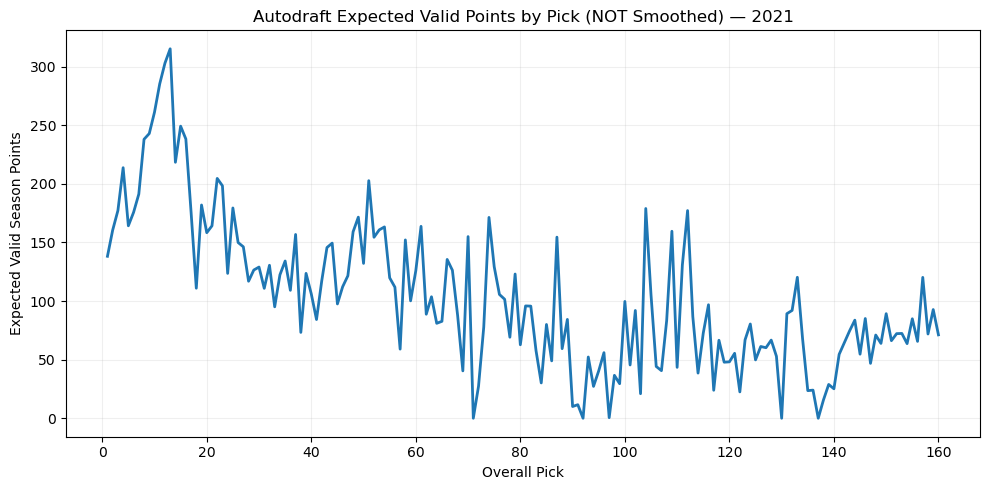

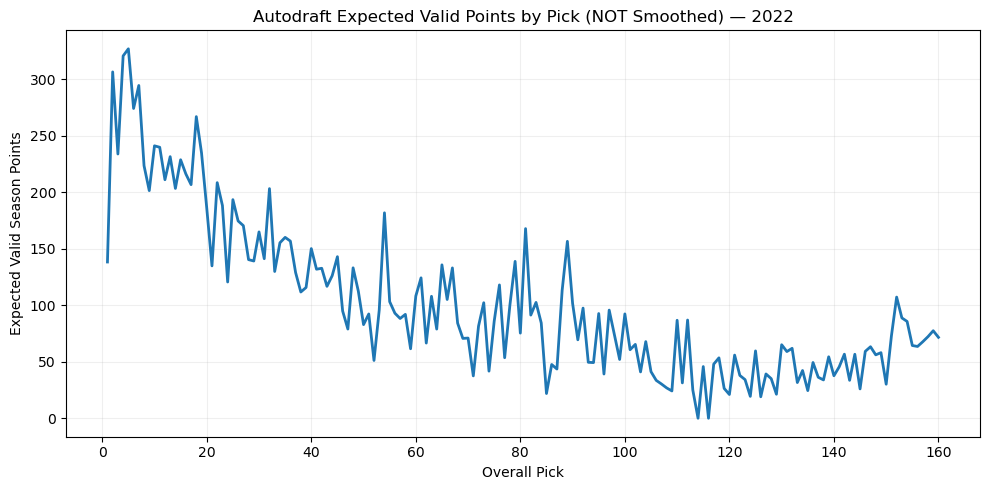

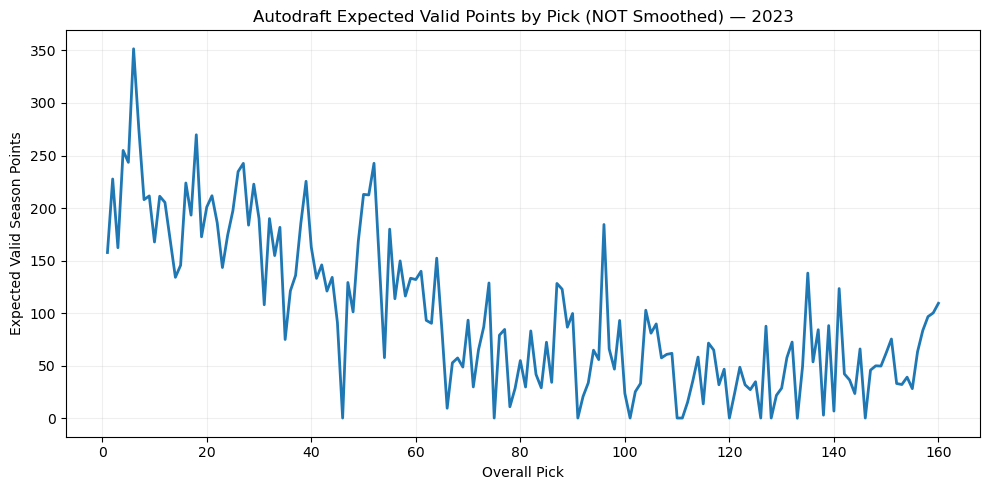

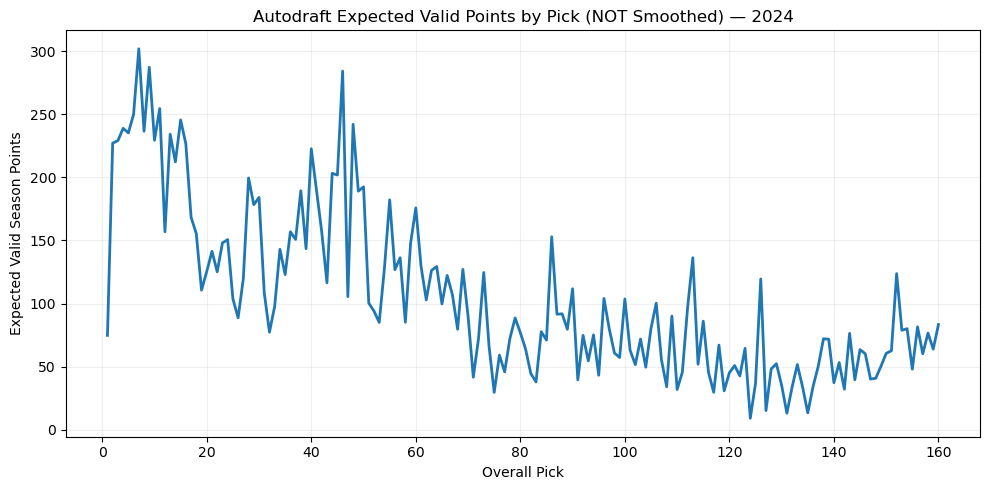

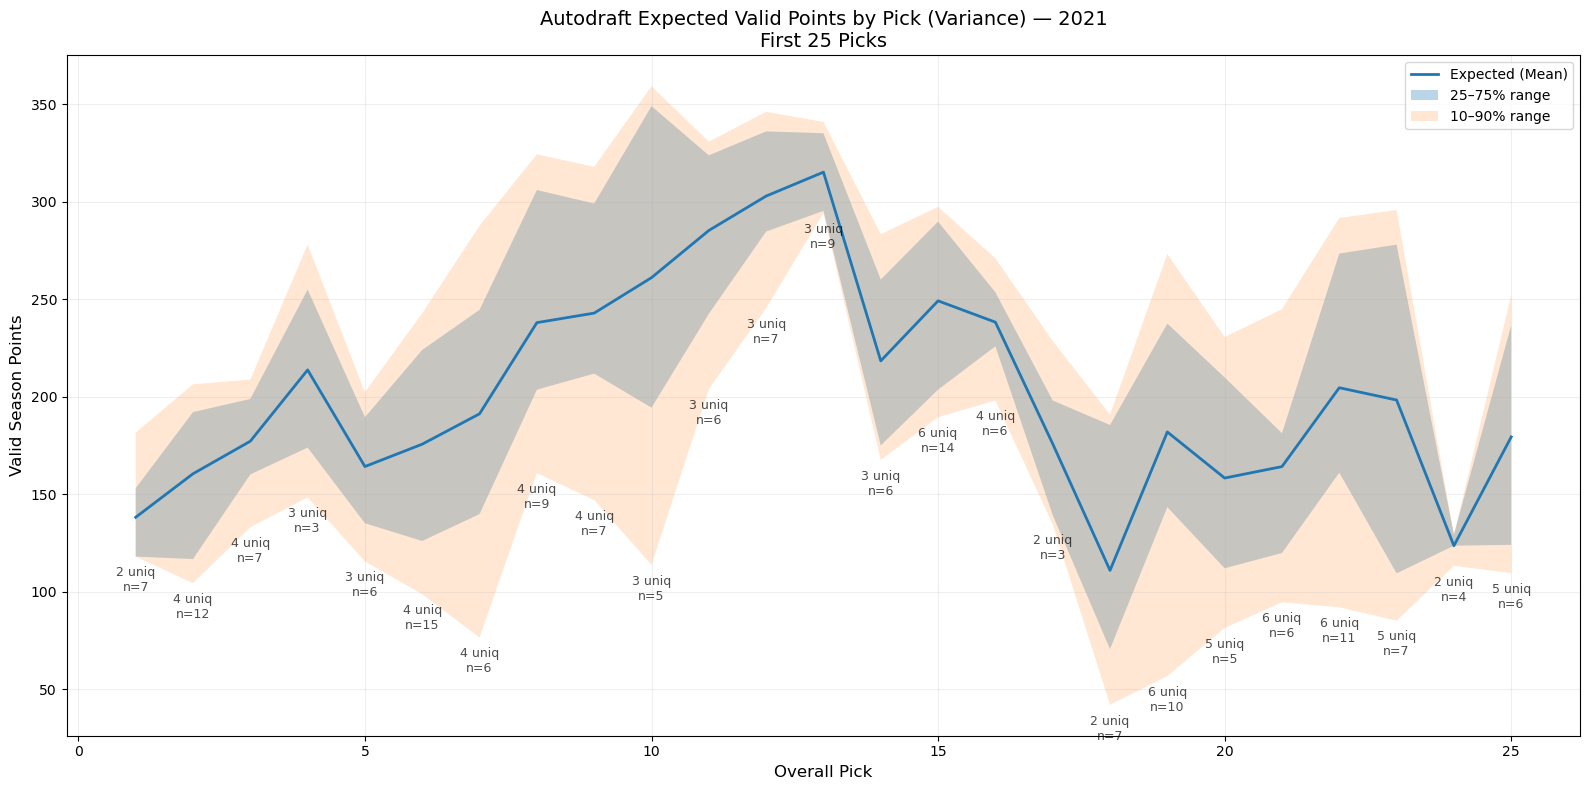

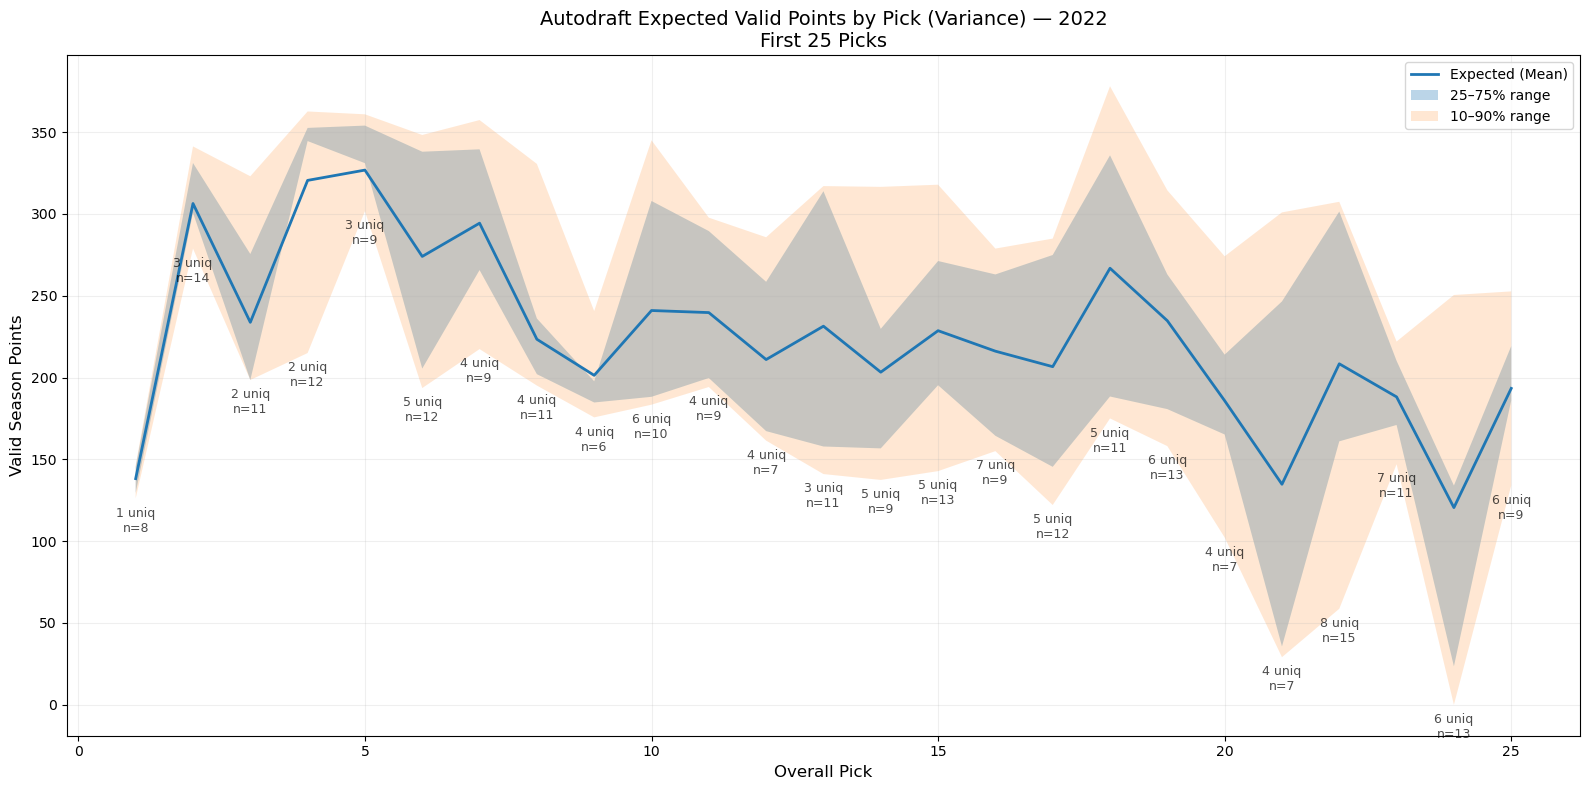

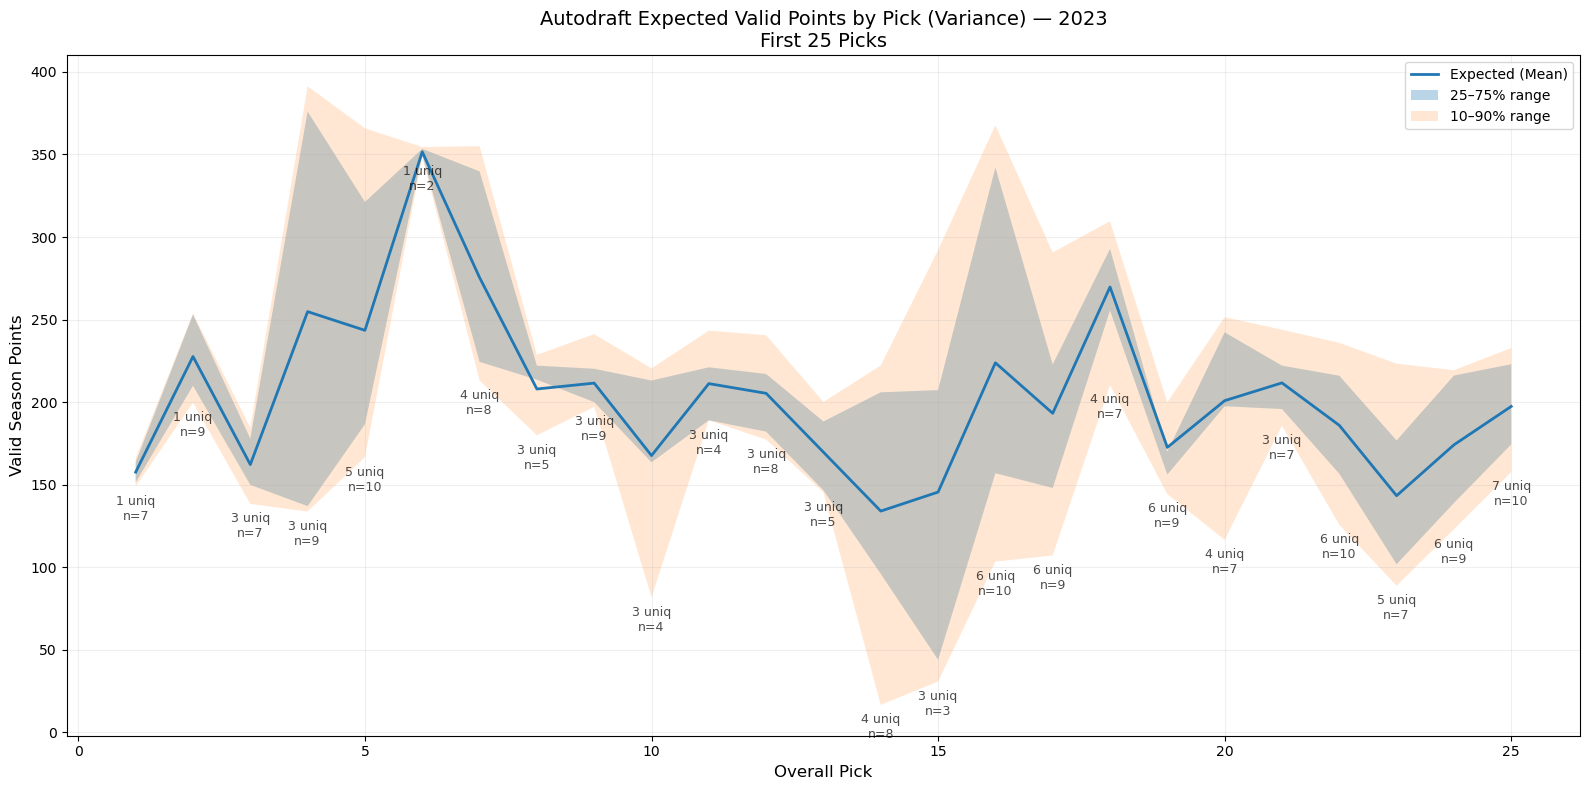

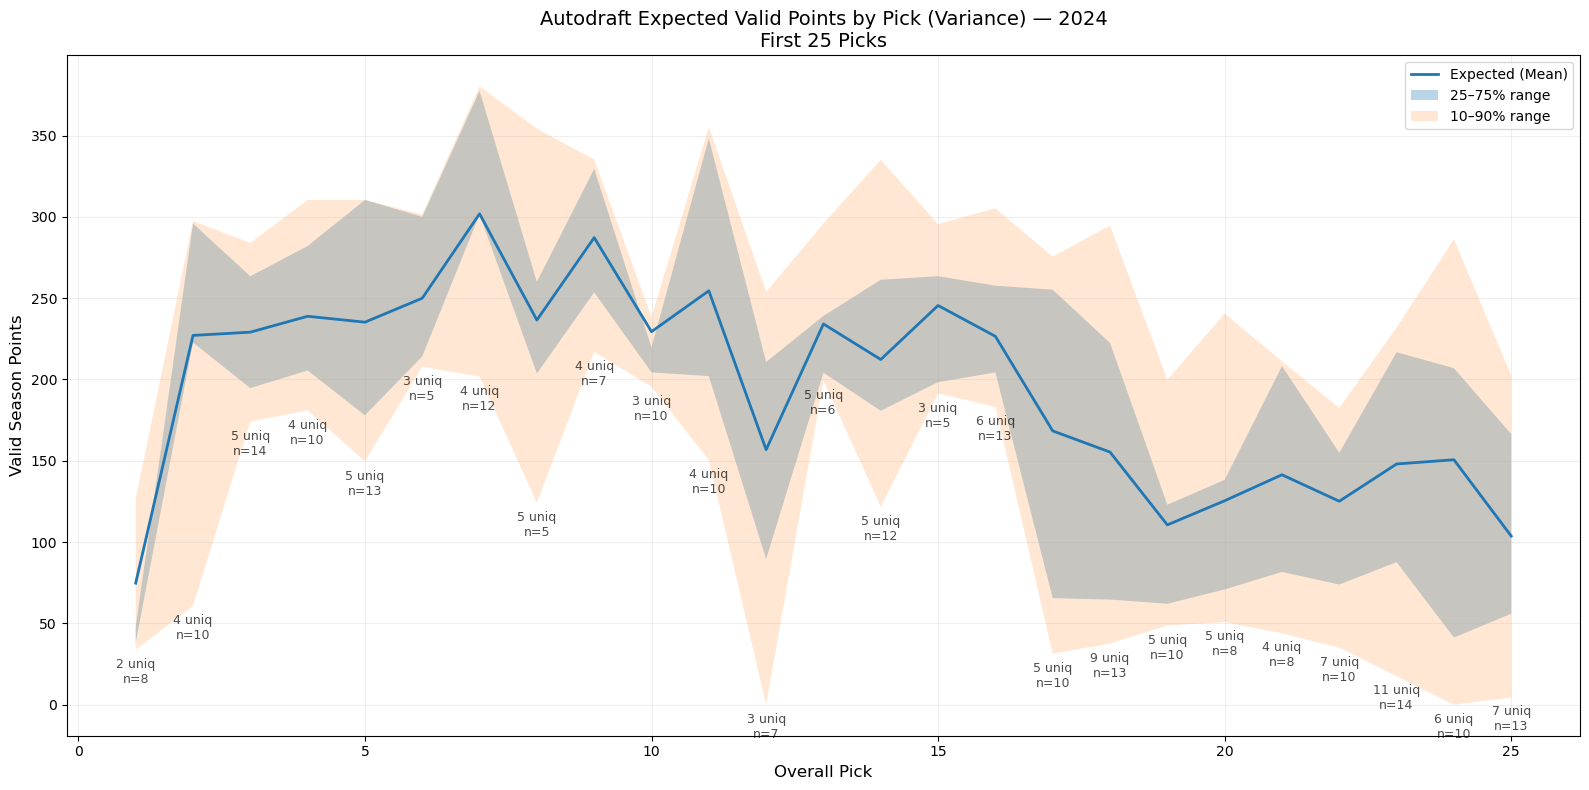

In [9]:
# Per-Season Expected Values
# Shows how expected values vary by year
analyzer.plot_per_season_expected_values(zoom_first_25=True)


### Observations: Per-Season Expected Values

**Key Findings:**

- **Year-to-Year Variation**: Expected values fluctuate by season, reflecting changes in player talent distribution and league dynamics
- **Consistent Patterns**: Despite year-to-year variation, the general trend of declining value by pick number remains consistent
- **Early Pick Stability**: Top picks (1-25) show more consistent expected values across years compared to later rounds

**Strategic Insight**: Understanding year-to-year variation helps drafters adjust expectations and identify when certain draft positions offer exceptional value.


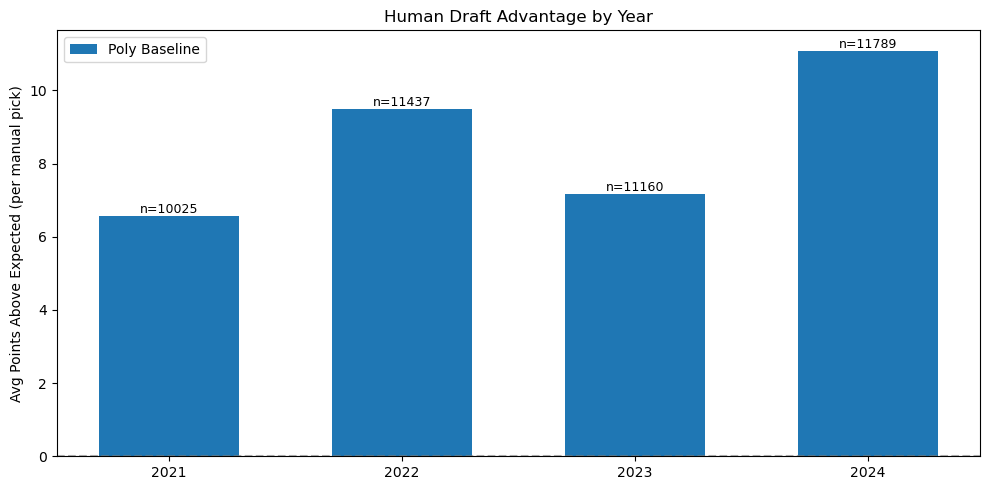


Human Advantage by Year:
   Year  Manual_Picks  Avg_Points_Added
0  2021         10025          6.553773
1  2022         11437          9.485641
2  2023         11160          7.170911
3  2024         11789         11.084716


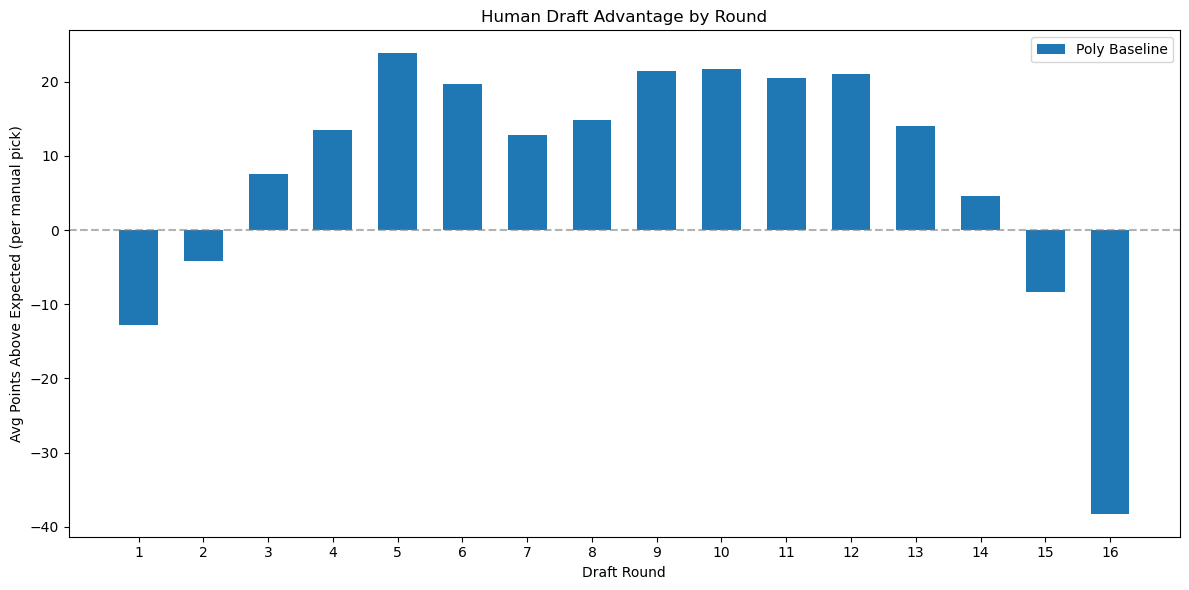


Human Advantage by Round:
   Round  Manual_Picks  Avg_Points_Added
0      1          2833        -12.774683
1      2          2854         -4.163175
2      3          2854          7.605781
3      4          2865         13.553073
4      5          2863         23.825107
5      6          2859         19.712027
6      7          2861         12.870015
7      8          2842         14.833320
8      9          2828         21.444989
9     10          2801         21.755044


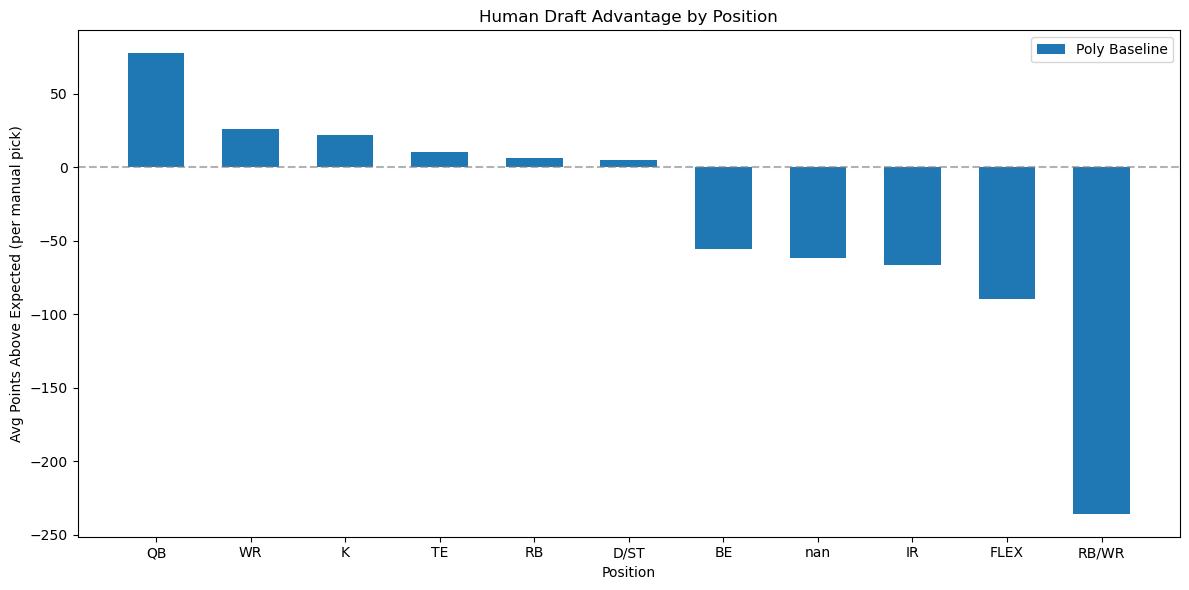


Human Advantage by Position:
   Position  Manual_Picks  Avg_Points_Added
5        QB          4374         77.414000
9        WR         11775         25.981031
4         K          2807         22.154130
8        TE          4188         10.632987
6        RB         10520          6.373585
1      D/ST          2985          4.589616
0        BE          6774        -55.555399
10      NaN           481        -61.809074
3        IR           201        -66.528455
2      FLEX           304        -89.483770
7     RB/WR             2       -235.761419


In [10]:
# Human Draft Advantage Analysis
# Compare manual picks vs autodraft baseline

# By Year
advantage_by_year = analyzer.plot_human_advantage_by_year(baseline="Poly")
print("\nHuman Advantage by Year:")
print(advantage_by_year)

# By Round
advantage_by_round = analyzer.plot_human_advantage_by_round(baseline="Poly")
print("\nHuman Advantage by Round:")
print(advantage_by_round.head(10))

# By Position
advantage_by_position = analyzer.plot_human_advantage_by_position(baseline="Poly")
print("\nHuman Advantage by Position:")
print(advantage_by_position)


### Observations: Human Draft Advantage Analysis

**Key Findings:**

#### By Year:
- Human advantage has increased over time (2021: +6.6 points, 2024: +11.1 points)
- Suggests improving draft strategies or better access to information

#### By Round:
- **Early Rounds (1-2)**: Negative advantage suggests autodraft algorithms perform well on consensus top players
- **Mid-Rounds (3-7)**: Strong positive advantage (+7 to +24 points) where human judgment adds most value
- **Late Rounds (8-10)**: Continued positive advantage, indicating human ability to find value in deeper picks

#### By Position:
- **QB**: Largest advantage (+77 points) - human drafters excel at quarterback evaluation
- **WR**: Strong advantage (+26 points) - position depth allows for strategic selection
- **RB**: Modest advantage (+6 points) - more predictable position with less variance
- **Bench/IR**: Negative values expected (these are non-starting positions)

**Strategic Insight**: Human drafters add the most value in mid-rounds and at quarterback, suggesting these areas deserve extra attention during draft preparation.


#### Injury Data Collection

Collect NFL injury data for analysis. This data will be used to analyze how injuries affect player performance.


In [11]:
# Collect injury data for years 2021-2024
injury_results = collect_injury_data(
    years=range(2021, 2025),
    output_dir="data/raw/injuries"
)

print(f"\nCollected injury data for {injury_results['total_years']} years")
print(f"  Total records: {injury_results['total_records']:,}")



Output directory: data/raw/injuries

Fetching injury data for 2021...
  Saved 5,587 records to data/raw/injuries\nfl_injuries_2021.csv (0.5s)

Fetching injury data for 2022...
  Saved 5,682 records to data/raw/injuries\nfl_injuries_2022.csv (0.4s)

Fetching injury data for 2023...
  Saved 5,599 records to data/raw/injuries\nfl_injuries_2023.csv (0.4s)

Fetching injury data for 2024...
  Saved 6,215 records to data/raw/injuries\nfl_injuries_2024.csv (0.3s)

INJURY DATA COLLECTION COMPLETE!
Total years processed: 4
Total records: 23,083

Collected injury data for 4 years
  Total records: 23,083


#### Injury Impact Analysis

Analyze how injuries affect player performance:
1. **Point Differential Analysis**: Compare actual vs projected points for injured vs healthy players
2. **Injury Type Impact**: How different injury types (hamstring, wrist, ankle, etc.) affect performance
3. **Position-Specific Impact**: How injuries affect different positions (QB, RB, WR, TE)
5. **Decision Support**: Help decide whether to start an injured player vs healthy alternative


In [12]:
# Initialize Injury Analyzer
injury_analyzer = InjuryAnalyzer(
    injury_dir="data/raw/injuries",
    lineup_data_path=None,  # Auto-detect from data/raw/espn
    years=range(2021, 2025),
    verbose=True
)


Initializing InjuryAnalyzer...


In [13]:
# Load data 
injury_analyzer.load_injury_data()
injury_analyzer.load_lineup_data()


Loading injury data...
  Loaded 5,587 records from 2021
  Loaded 5,682 records from 2022
  Loaded 5,599 records from 2023
  Loaded 6,215 records from 2024

  Total injury records: 22,203
  Years: 2021 - 2024
  Unique players: 2,649
  Injury statuses: {'No Injury': 11797, 'Questionable': 5853, 'Out': 3920, 'Doubtful': 627, 'Note': 6}

Loading lineup data...

  Total lineup records: 1,100,412
  Years: 2024 - 2024
  Unique players: 829


,League_ID,Week,Team,Player,Slot,Points,Projected_Points,Position,Is_Starter,Year,player_norm,point_differential
0,1240358,4,5,Alvin Kamara,RB,24.90,18.97,RB,1,2024,Alvin Kamara,5.93
1,1240358,4,5,Jordan Mason,RB,24.00,17.20,RB,1,2024,Jordan Mason,6.80
2,1240358,4,5,Lamar Jackson,BE,23.64,19.84,QB,0,2024,Lamar Jackson,3.80
3,1240358,4,5,Aaron Jones,RB/WR/TE,17.90,16.83,RB,1,2024,Aaron Jones,1.07
4,1240358,4,5,Patrick Mahomes,QB,13.00,17.55,QB,1,2024,Patrick Mahomes,-4.55
...,...,...,...,...,...,...,...,...,...,...,...,...
1100407,933533,17,10,Chuba Hubbard,BE,0.00,0.00,RB,0,2024,Chuba Hubbard,0.00
1100408,933533,17,10,Aaron Rodgers,BE,0.48,17.69,QB,0,2024,Aaron Rodgers,-17.21
1100409,933533,17,10,Deshaun Watson,BE,0.00,0.00,QB,0,2024,Deshaun Watson,0.00
1100410,933533,17,10,Jets D/ST,D/ST,-3.00,2.26,D/ST,1,2024,Jets D/ST,-5.26


In [14]:
# Calculate baselines
injury_analyzer.calculate_player_baselines()


Calculating player baselines (healthy week performance)...
  Calculated baselines for 826 players in 0.6 seconds
  Average baseline: -0.78 points
  Players with 1+ healthy weeks: 826
  Players with 5+ healthy weeks: 701


,player_norm,baseline_avg,baseline_std,n_weeks,position
0,49ers Coach,-1.641818,6.216433,121,HC
1,49ers D/ST,0.409482,6.197485,5274,D/ST
2,49ers TQB,-1.086562,11.890429,64,TQB
3,A'Shawn Robinson,2.458667,2.398800,15,DT
4,A.J. Brown,0.077241,6.882243,5342,WR
...,...,...,...,...,...
821,Zamir White,-6.505215,3.470234,1910,RB
822,Zane Gonzalez,-2.705591,1.575367,127,K
823,Zay Flowers,-1.040661,8.401636,5825,WR
824,Zay Jones,0.000000,0.000000,4,WR


In [15]:
# Merge data
injury_analyzer.merge_injury_lineup_data()


Merging injury and lineup data...
  Merged 1,100,434 records
  Injury weeks: 100,269
  Healthy weeks: 1,000,165


,League_ID,Week,Team,Player,Slot,Points,Projected_Points,Position,Is_Starter,Year,...,point_differential,season,week,position,has_injury,injury_status,injury_type,baseline_avg,baseline_std,n_weeks
0,1240358,4,5,Alvin Kamara,RB,24.90,18.97,RB,1,2024,...,5.93,2024.0,4.0,RB,True,Questionable,Hip,-1.143279,10.332975,5413.0
1,1240358,4,5,Jordan Mason,RB,24.00,17.20,RB,1,2024,...,6.80,NaN,NaN,RB,False,No Injury,None,-2.380642,7.964480,4645.0
2,1240358,4,5,Lamar Jackson,BE,23.64,19.84,QB,0,2024,...,3.80,NaN,NaN,QB,False,No Injury,None,3.423171,7.486981,6522.0
3,1240358,4,5,Aaron Jones,RB/WR/TE,17.90,16.83,RB,1,2024,...,1.07,NaN,NaN,RB,False,No Injury,None,-1.621933,6.475051,6584.0
4,1240358,4,5,Patrick Mahomes,QB,13.00,17.55,QB,1,2024,...,-4.55,NaN,NaN,QB,False,No Injury,None,0.298059,6.511983,6431.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100429,933533,17,10,Chuba Hubbard,BE,0.00,0.00,RB,0,2024,...,0.00,2024.0,17.0,RB,True,Questionable,Knee,1.527460,8.965400,6047.0
1100430,933533,17,10,Aaron Rodgers,BE,0.48,17.69,QB,0,2024,...,-17.21,2024.0,17.0,QB,False,No Injury,None,-2.551406,7.989987,3934.0
1100431,933533,17,10,Deshaun Watson,BE,0.00,0.00,QB,0,2024,...,0.00,NaN,NaN,QB,False,No Injury,None,-3.286349,4.510754,975.0
1100432,933533,17,10,Jets D/ST,D/ST,-3.00,2.26,D/ST,1,2024,...,-5.26,NaN,NaN,D/ST,False,No Injury,None,-0.527617,6.562650,4209.0


In [16]:
# Prepare analysis data 
analysis_df = injury_analyzer.prepare_analysis_data()


Preparing analysis data...
  Prepared 1,100,434 records in 0.3 seconds


In [17]:
# Compute aggregated stats
agg_stats = injury_analyzer.compute_aggregated_stats(analysis_df)

# Store for later use
individual_records = analysis_df


Computing aggregated statistics...
  Computed 254 aggregated statistics in 0.2 seconds


In [18]:
# Save results
output_dir = Path("data/preprocessed")
output_dir.mkdir(parents=True, exist_ok=True)
agg_stats.to_csv(output_dir / "injury_impact_aggregated.csv", index=False)
individual_records.to_csv(output_dir / "injury_impact_individual.csv", index=False)

#### Statistical Reliability: Population Thresholds

To ensure reliable analysis, we apply minimum population thresholds:
- **Heatmaps**: Only show injury type/position/status combinations with ≥30 observations

This prevents misleading averages from rare injuries (e.g., a single player with unusual performance).
Higher thresholds ensure statistical significance and generalizable insights.

#### Injury Impact Visualizations

Create visualizations to understand injury impact patterns.


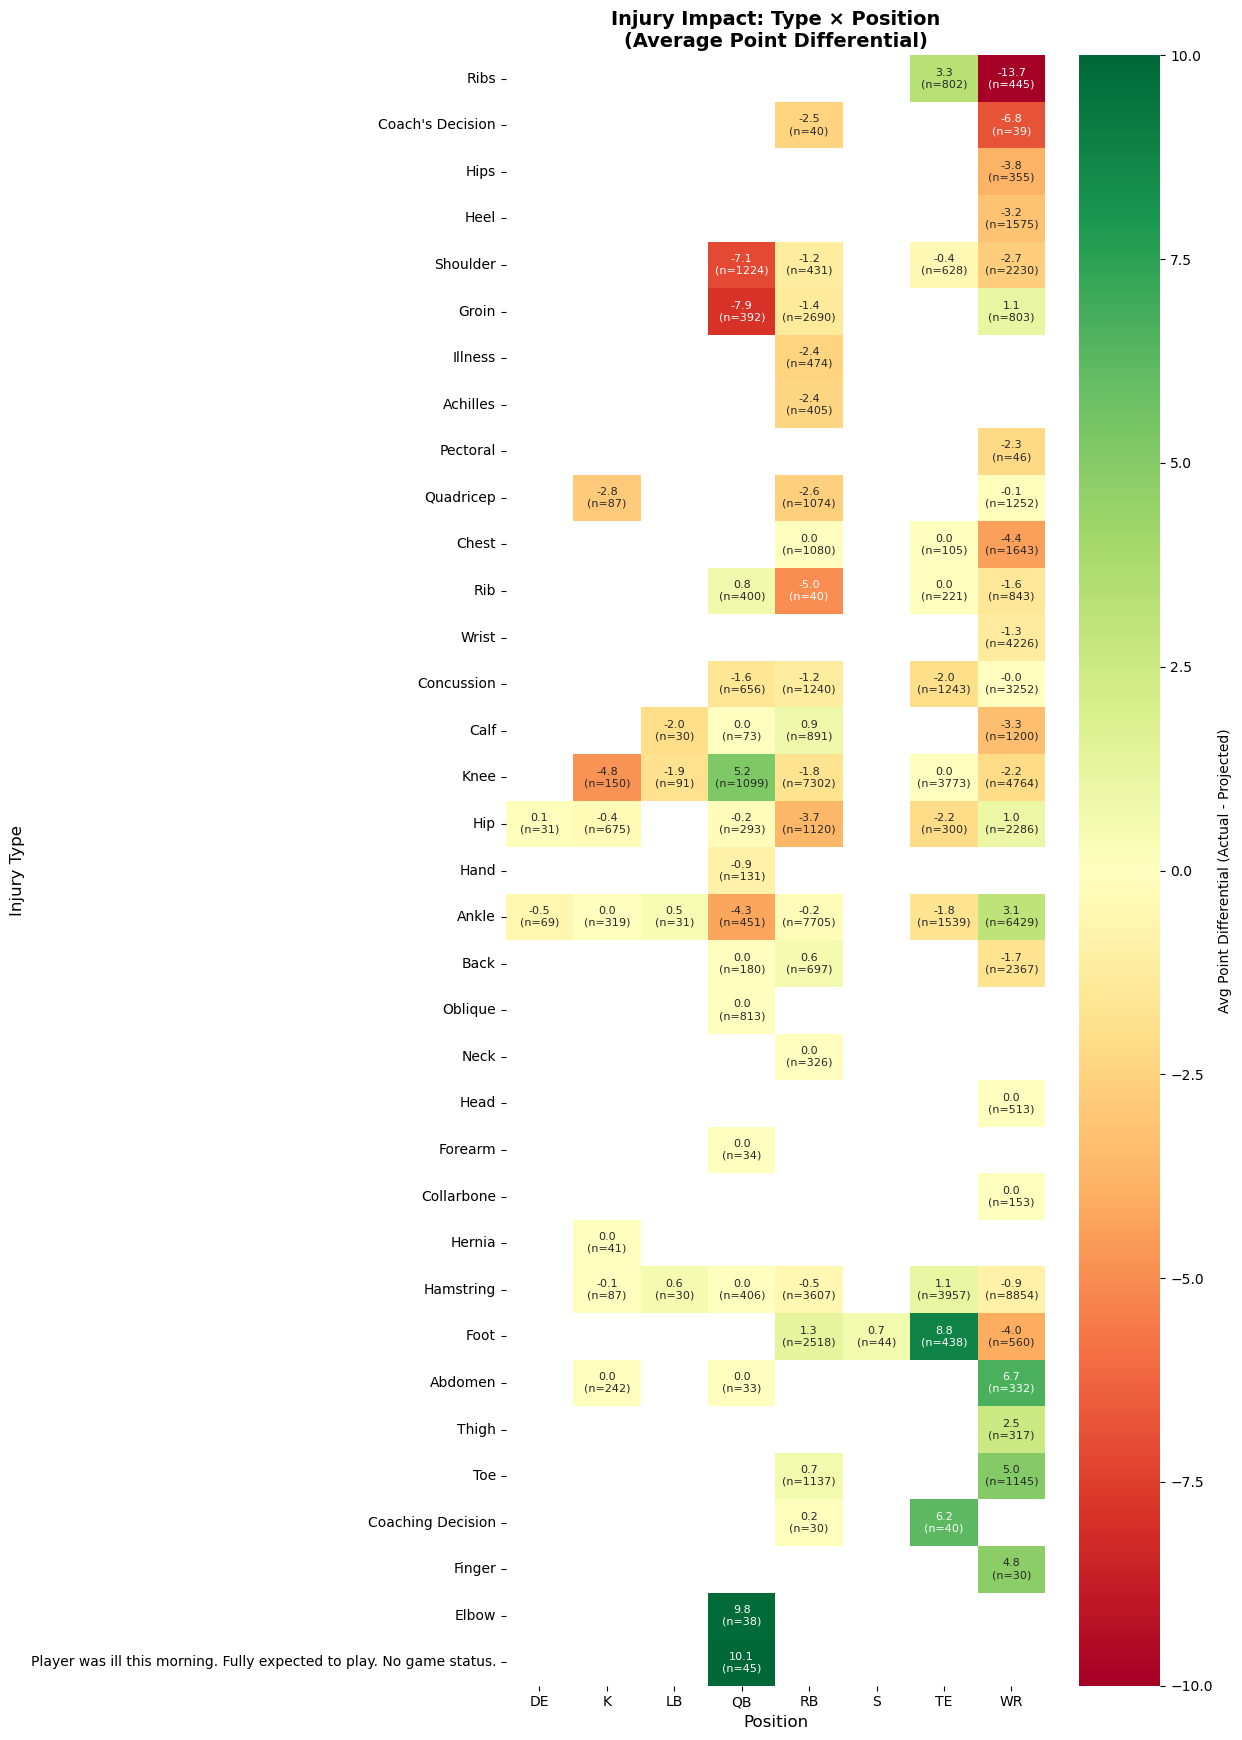

In [19]:
# Heatmap 1: Injury Type × Position
# Parameters: min_population (int, default=30), show_sample_sizes (bool, default=True), save_path (str, optional)
injury_analyzer.plot_heatmap_type_position()
plt.show()


### Observations: Injury Type × Position Heatmap

**Key Findings:**

- **Position-Specific Impact**: Different positions show varying sensitivity to injury types
- **Injury Type Patterns**: Some injury types (e.g., shoulder) have consistent negative impact across positions
- **High-Impact Combinations**: Certain injury type/position combinations show particularly strong negative effects and some strong positive effects.

**Strategic Insight**: When evaluating injured players, consider both the injury type and position. A ribs injury to a WR may be more impactful than a finger injury. 


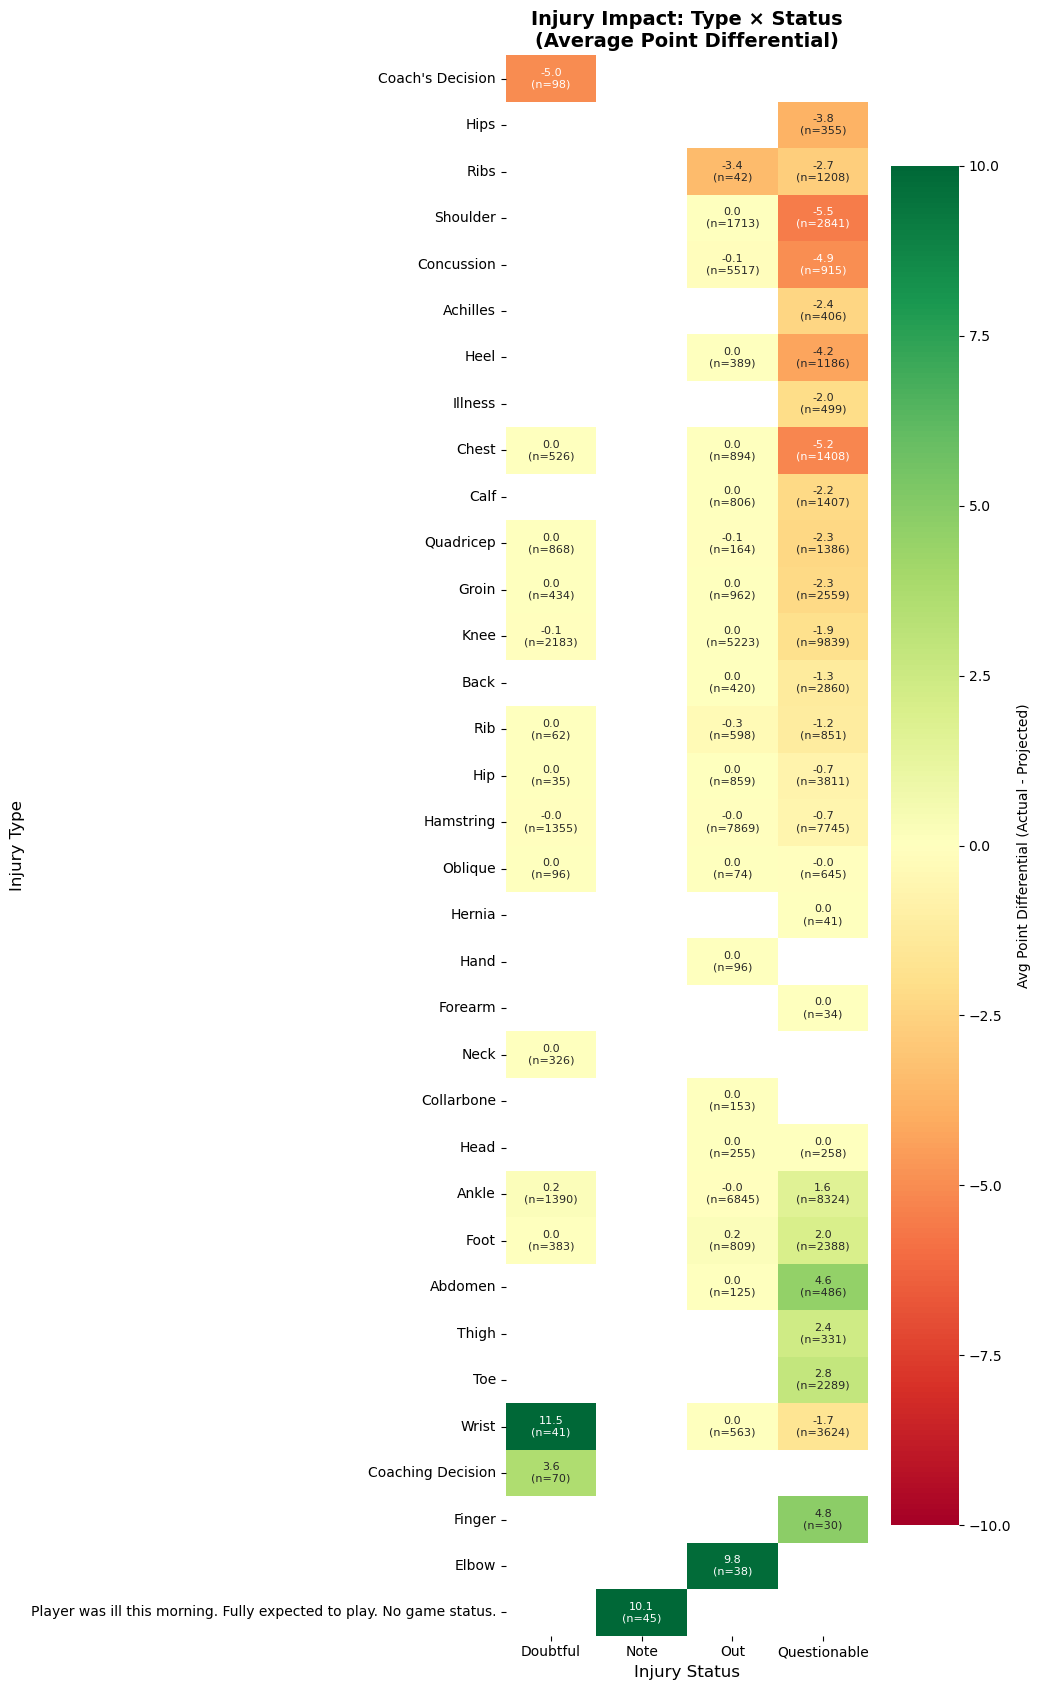

In [20]:
# Heatmap 2: Injury Type × Status
# Parameters: min_population (int, default=30), show_sample_sizes (bool, default=True), save_path (str, optional)
injury_analyzer.plot_heatmap_type_status()
plt.show()


### Observations: Injury Type × Status Heatmap

**Key Findings:**

- **Status Severity**: Severity seems to be taken into account by projections. Out, doubtful, and questionable are all in reasonable expected points range. The most variability comes in the questionable category. 
- **Injury Type Variation**: Some injury types (e.g., ribs) show consistent negative impact across multiple statuses
- **Status Reliability**: "Questionable" status shows high variance - some injuries seem to be less bothersome than others.

**Strategic Insight**: Injury status alone isn't predictive. The injury status must be combined with the injury type to make a decision on whether to start or sit a player.


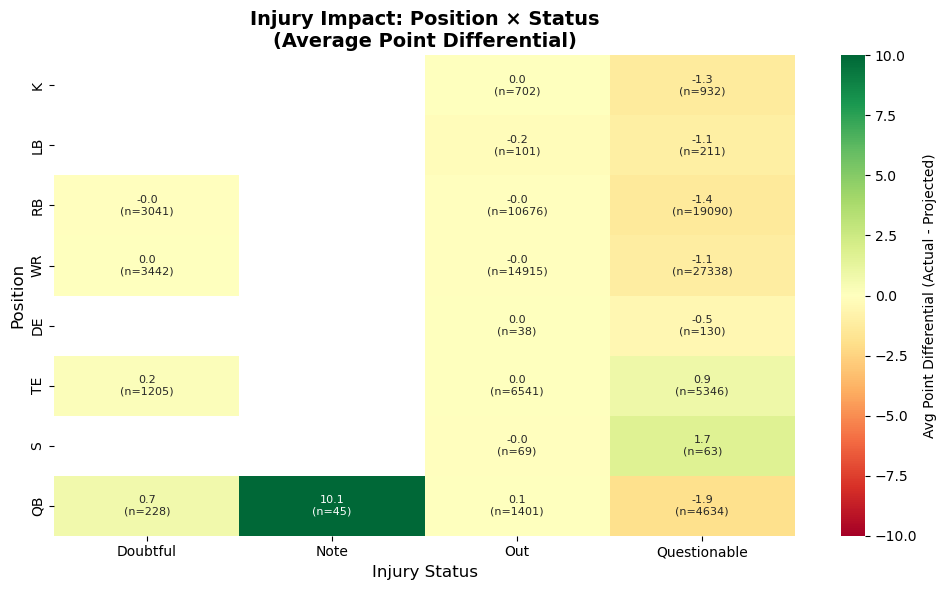

In [21]:
# Heatmap 3: Position × Status
# Parameters: min_population (int, default=30), show_sample_sizes (bool, default=True), save_path (str, optional)
injury_analyzer.plot_heatmap_position_status()
plt.show()


### Observations: Position × Status Heatmap

**Key Findings:**

- **Position Sensitivity**: Some positions (e.g., RB) may be more affected by injuries than others (e.g., TE)
- **Status Impact by Position**: "Out" status affects all positions similarly, but "Questionable" still shows high variability accross position.
- **Consistent Patterns**: Positions with similar roles (e.g., RB, WR) may show similar injury impact patterns, and Out seems to have dead on expected point predictions which should be expected.

**Strategic Insight**: When deciding whether to start an injured player, consider both their position and injury status. A "Questionable" tight end may be safer than a "Questionable" running back.

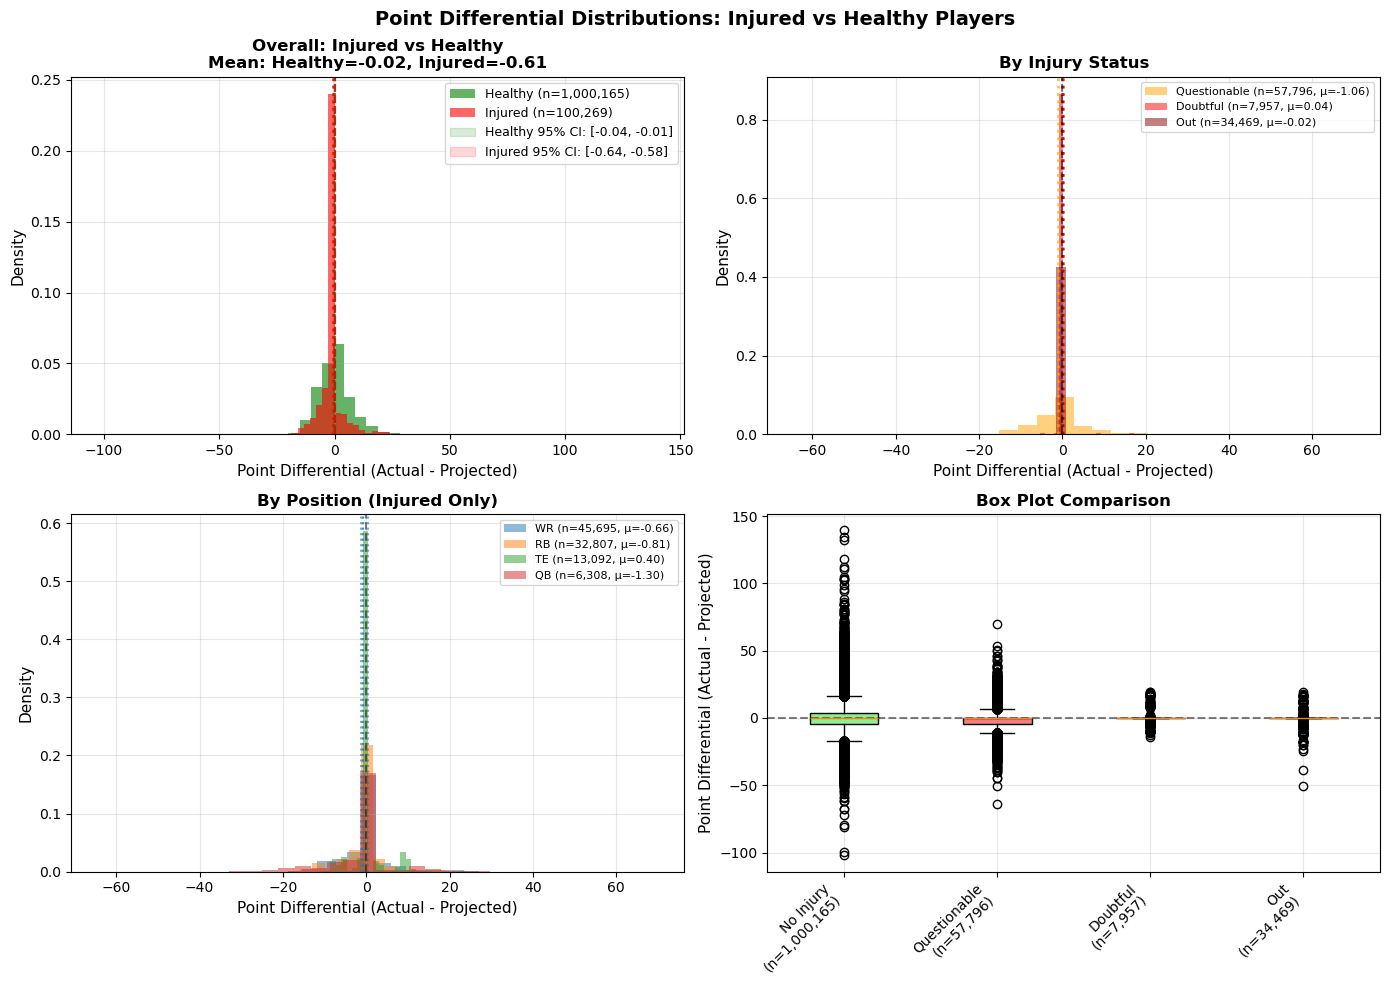

In [22]:
# Point Differential Distribution
# Compare distributions of point differentials for injured vs healthy players
# Parameters: save_path (str, optional)
injury_analyzer.plot_point_differential_distribution()
plt.show()


### Observations: Point Differential Distribution

**Key Findings:**

#### Overall Distribution:
- **Healthy Players**: Distribution centered near zero
- **Injured Players**: Distribution shifted slightly left indicating maringal underperformance
- **Mean Difference**: Clear separation between healthy and injured demonstrates there is a measurable injury impact

#### By Injury Status:
- **No Injury**: Distribution centered around zero as expected
- **Questionable**: Wide distribution leading to a high uncertainty
- **Doubtful/Out**: Point predictions for out/doubtful seem to be relatively on target with much less variance than Questionable.

#### By Position:
- Different positions show varying sensitivity to injuries
- QBs seem to have the highest variance of the position groups.

**Strategic Insight**: The distribution shapes help quantify risk. "Questionable" players have high variance. They could outperform or significantly underperform. This infomration can be used to make informed risk tolerance decisions when setting your weekly lineup. 

In [23]:
# Preview aggregated statistics
print("Top 10 Injury Impact Combinations (by average point differential):")
print(agg_stats.nlargest(10, 'avg_point_differential')[['injury_type', 'position', 'injury_status', 'n_weeks', 'n_players', 'avg_point_differential']])

print("\n\nBottom 10 Injury Impact Combinations (worst performers):")
print(agg_stats.nsmallest(10, 'avg_point_differential')[['injury_type', 'position', 'injury_status', 'n_weeks', 'n_players', 'avg_point_differential']])


Top 10 Injury Impact Combinations (by average point differential):
                                           injury_type position injury_status  \
250                                              Wrist       WR      Doubtful   
201  Player was ill this morning. Fully expected to...       QB          Note   
80                                               Elbow       QB           Out   
92                                                Foot       TE  Questionable   
34                                                Back        P  Questionable   
20                                               Ankle       QB      Doubtful   
50                                                Calf       TE  Questionable   
7                                              Abdomen       WR  Questionable   
64                                   Coaching Decision       TE      Doubtful   
153                                            Illness       CB  Questionable   

     n_weeks  n_players  avg_point_differ

# Baseline Analysis: Waiver Wire and Start/Sit

This section extends our analysis beyond the draft to examine two additional decision points in fantasy football: **waiver wire acquisitions** and **start/sit decisions**. We establish baselines for each and measure their impact relative to draft decisions.

## Overview

1. **Waiver Wire Baseline**: The baseline for Waiver Wire is 25 percentile of points added for all league-years combined.
2. **Start/Sit Baseline**: Uses projected-optimal lineups as a baseline to measure the quality of weekly start/sit decisions.
3. **Combined Analysis**: Integrates all three baselines (Draft, Waiver, Start/Sit) to show cumulative points added over the course of a season.

---


## Waiver Wire Baseline Analysis

Waiver wire decisions involve adding players from the free agent pool during the season. We measure the value of these decisions by:
- Tracking when players were added and dropped
- Counting only points scored when the player was in the optimal lineup
- Comparing total waiver points to a minimal competency baseline (Q25 of team-season waiver rates)

### Step 1: Load Transaction Data


In [24]:
# Load transaction data and filter to same league-years as our analysis
transactions_raw = analyzer.load_multi_season_transactions(lineups_filt=lineups_filt)

print(f"Loaded {len(transactions_raw):,} transaction records")
print(f"Transaction types: {transactions_raw['Action_norm'].value_counts().to_dict()}")


Loaded 116,318 transaction records
Transaction types: {'WAIVER_ADD': 58641, 'DROP': 54905, 'TRADE_JOIN': 2772}


### Step 2: Build Waiver Add Stints

A "stint" represents the period from when a player was added via waiver/free agent until they were dropped (or end of season).


In [25]:
# Build waiver add stints
# min_week_after_add=1 means we only count points from the week AFTER the add
# (conservative approach to handle timing ambiguity)
waiver_stints = analyzer.build_waiver_add_stints(
    transactions_raw,
    season_end_week=17,
    min_week_after_add=1
)

print(f"Created {len(waiver_stints):,} waiver stints")
print(f"\nSample stints:")
print(waiver_stints.head(10))


Created 42,169 waiver stints

Sample stints:
    League_ID  Year  Team      Player_norm  Add_Week  Start_Week_For_Credit  \
3      760435  2022     1        Cole Kmet        11                     12   
4      760435  2022     1     Daniel Jones        16                     17   
5      760435  2022     1     Drake London        16                     17   
8      760435  2022     1      Graham Gano        10                     11   
10     760435  2022     1     Greg Dulcich        14                     15   
11     760435  2022     1    Isaiah Likely         9                     10   
12     760435  2022     1    Jarvis Landry        11                     12   
13     760435  2022     1      Jason Myers        12                     13   
14     760435  2022     1  Jimmy Garoppolo        12                     13   
16     760435  2022     1   Kadarius Toney         8                      9   

    End_Week    Add_Type  
3         17  WAIVER_ADD  
4         17  WAIVER_ADD  
5   

### Step 3: Compute Valid Waiver Points

Valid points are only counted when the player was selected in the optimal lineup during their stint window.


In [26]:
# Compute valid waiver points using optimal lineup selections
waiver_with_valid = analyzer.compute_valid_waiver_points(
    waiver_stints,
    optimal_selected
)

print(f"Computed valid points for {len(waiver_with_valid):,} waiver stints")
print(f"\nTop waiver pickups by valid points:")
print(waiver_with_valid.sort_values("Valid_Points", ascending=False).head(20))


Computed valid points for 42,169 waiver stints

Top waiver pickups by valid points:
       League_ID  Year  Team     Player_norm  Add_Week  Start_Week_For_Credit  \
12737    1070186  2024    16      Jared Goff         5                      6   
12750    1070186  2024    17  Baker Mayfield         3                      4   
9463     1008665  2024     8  Baker Mayfield         2                      3   
19536    1195564  2024    10  Baker Mayfield         2                      3   
21254    1209408  2024     2  Jayden Daniels         2                      3   
1745      867875  2024     1  Baker Mayfield         2                      3   
25606    1268773  2023     4     Brock Purdy         2                      3   
33645    1381421  2024     7  Baker Mayfield         3                      4   
29001    1320877  2024     4  Baker Mayfield         2                      3   
21280    1209408  2024     4  Baker Mayfield         2                      3   
18274    1175115  2023   

### Step 4: Compute Waiver Baseline Candidates

We calculate multiple baseline options (mean, median, Q25) to establish a minimal competency threshold for waiver wire performance.


In [27]:
# Compute waiver baseline candidates
baseline_candidates, team_season = analyzer.compute_waiver_baseline_candidates(waiver_with_valid)

# Select Q25 as the canonical baseline (minimal competency, similar to autodraft baseline)
WAIVER_BASELINE_NAME = "q25_team_season"
WAIVER_BASELINE_VALUE = baseline_candidates[WAIVER_BASELINE_NAME]

print(f"Selected baseline: {WAIVER_BASELINE_NAME} = {WAIVER_BASELINE_VALUE:.3f} points per stint-week")
print(f"\nAll baseline candidates:")
baseline_table = pd.DataFrame({
    "Baseline": list(baseline_candidates.keys()),
    "Value (points per stint-week)": list(baseline_candidates.values()),
}).sort_values("Value (points per stint-week)")
print(baseline_table)


Selected baseline: q25_team_season = 4.865 points per stint-week

All baseline candidates:
             Baseline  Value (points per stint-week)
2     q25_team_season                       4.864883
1  median_team_season                       5.935527
0      avg_stint_week                       6.056750


### Step 5: Waiver Baseline Visualizations


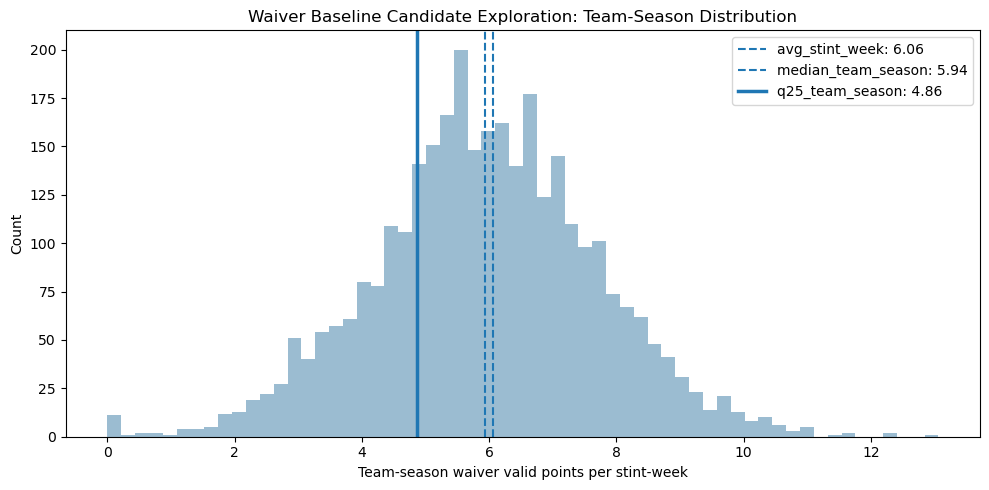

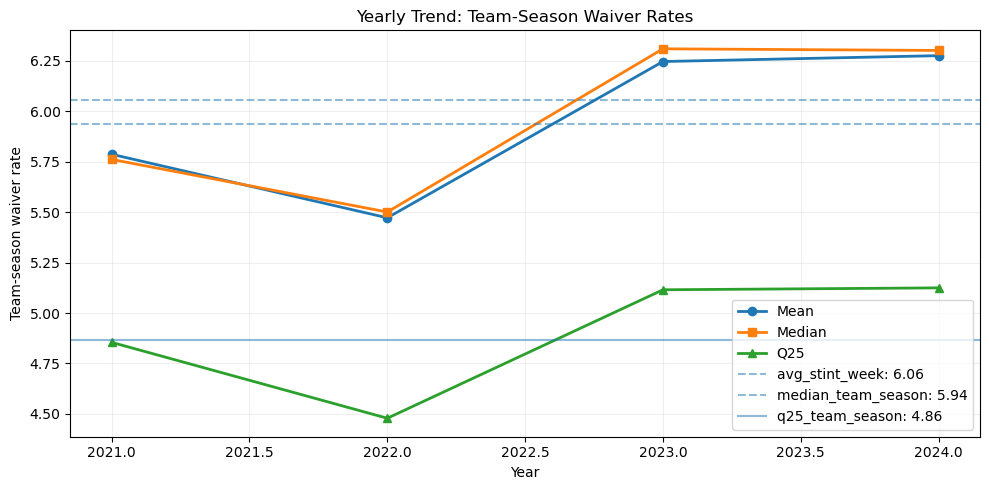

In [28]:
# Waiver baseline exploration
# Shows distribution of team-season waiver rates and yearly trends
analyzer.plot_waiver_baseline_exploration(
    team_season,
    baseline_candidates,
    waiver_baseline_name=WAIVER_BASELINE_NAME
)


### Step 6: Draft vs Waiver Points Added Over Time

This visualization shows cumulative points added from draft decisions (Week 0) and waiver decisions (Weeks 1-17).


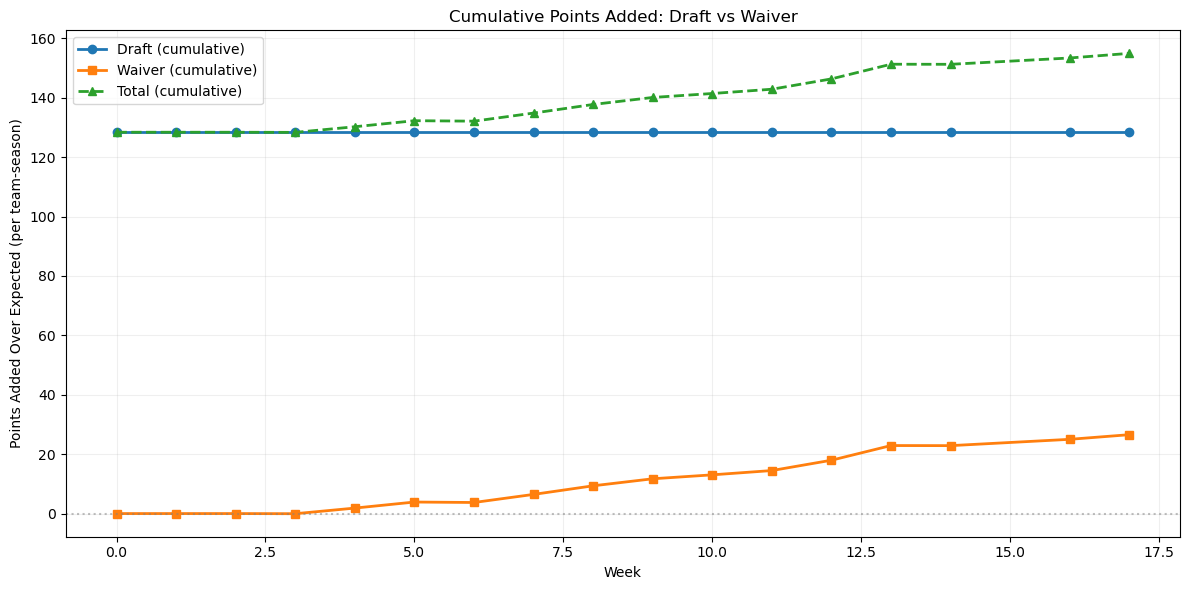

In [29]:
# Plot cumulative draft vs waiver points added
# Parameters:
#   draft_points_col: Which draft baseline to use ("Points_Added_Poly" or "Points_Added_Pooled")
#   manual_draft_only: Only include manual draft picks (exclude autodrafted)
#   season_end_week: Last week of season (default: 17)
#   ignore_weeks: Weeks to exclude from analysis (default: {15} - often has incomplete data)
#   agg_mode: "total" or "mean_per_team_season" (default: mean per team-season for normalization)
analyzer.plot_draft_vs_waiver_points(
    draft_scored,
    waiver_stints,
    optimal_selected,
    waiver_baseline_value=WAIVER_BASELINE_VALUE,
    draft_points_col="Points_Added_Poly",
    manual_draft_only=True,
    season_end_week=17,
    ignore_weeks={15},
    agg_mode="mean_per_team_season"
)


### Step 7: Yearly Draft vs Waiver Totals

Compare total points added from draft and waiver decisions by year, using multiple baseline options.


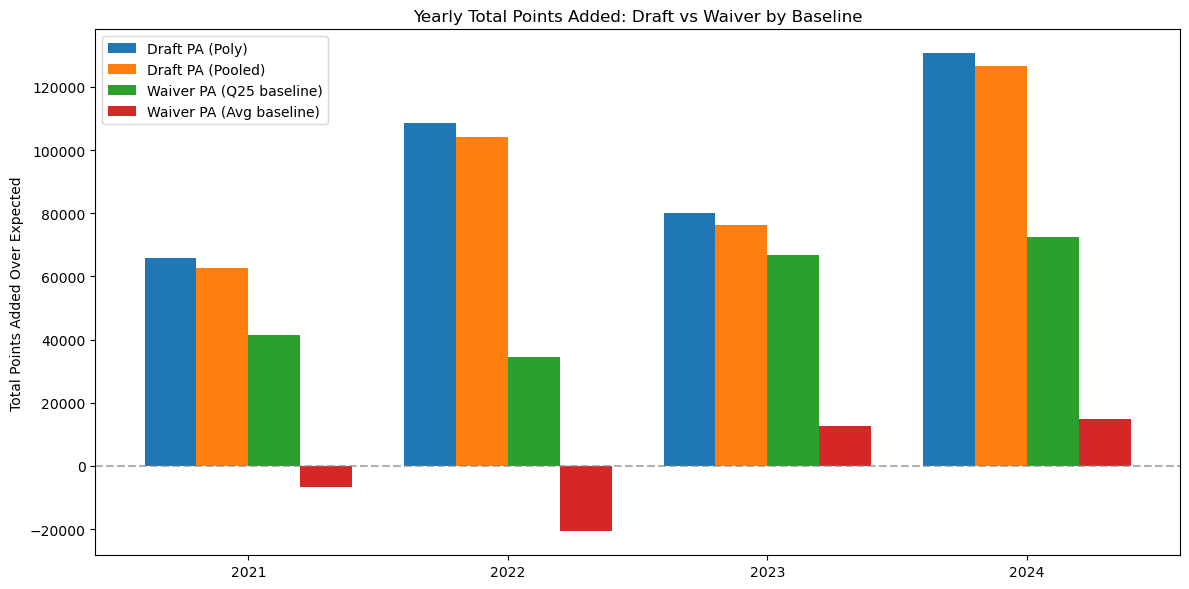


Yearly totals summary:
   Year  Draft_PA_Poly  Draft_PA_Pooled  Waiver_PA_Avg  Waiver_PA_Q25
0  2021   65701.577044     62768.565467   -6769.135312   41440.703009
1  2022  108487.276522    104251.775013  -20724.673018   34519.565802
2  2023   80027.366858     76262.819592   12524.572105   66644.880110
3  2024  130677.713752    126585.136884   14969.236225   72373.138499


In [30]:
# Yearly totals comparison
# Shows draft baselines (Poly, Pooled) vs waiver baselines (Q25, Average)
yearly_totals = analyzer.plot_yearly_draft_waiver_totals(
    draft_scored,
    waiver_with_valid,
    baseline_candidates,
    manual_draft_only=True
)

print("\nYearly totals summary:")
print(yearly_totals)


### Observations: Waiver Wire Baseline Analysis

**Key Findings:**

- **Baseline Selection**: Q25 (25th percentile) of team-season waiver rates provides a minimal competency baseline comparable to the autodraft baseline used for draft analysis.

- **Waiver Value**: Waiver wire decisions contribute meaningful points over the course of a season, though typically less than draft decisions on a per-decision basis.

- **Yearly Trends**: Waiver wire effectiveness may vary by year due to factors such as injury rates, breakout players, and league-wide roster management strategies.

- **Cumulative Impact**: When combined with draft decisions, waiver wire activity shows steady accumulation of points throughout the season.

---


## Start/Sit Baseline Analysis

Start/sit decisions involve choosing which players to start each week from your roster. We measure decision quality by:
- Comparing actual starter points to projected-optimal lineup points
- Using projected points as the baseline for fairness
- Only including complete team-weeks for accuracy

### Step 1: Compute Start/Sit Metrics


In [31]:
# Compute start/sit metrics using projected-optimal baseline
# This compares actual starter points to what the optimal lineup would have scored
# (based on projected points, not hindsight)
startsit_weekly, startsit_weekly_clean = analyzer.compute_startsit_metrics(
    lineups_filt,
    slot_counts={"QB": 1, "RB": 2, "WR": 2, "TE": 1, "FLEX": 1, "K": 1, "D/ST": 1},
    flex_eligible={"RB", "WR", "TE"}
)

print(f"Total team-weeks analyzed: {len(startsit_weekly):,}")
print(f"Complete team-weeks (used for analysis): {len(startsit_weekly_clean):,}")
print(f"\nStart/Sit points added summary:")
print(startsit_weekly_clean[["StartSit_PA", "StartSit_ProjGap"]].describe())


Total team-weeks analyzed: 54,839
Complete team-weeks (used for analysis): 52,568

Start/Sit points added summary:
        StartSit_PA  StartSit_ProjGap
count  52568.000000      52568.000000
mean      -1.724111         -1.626587
std       11.026887          5.198310
min      -93.300000        -64.650000
25%       -6.000000         -1.920000
50%        0.000000         -0.070000
75%        1.200000          0.000000
max       69.000000         22.640000


### Step 2: Start/Sit Visualizations


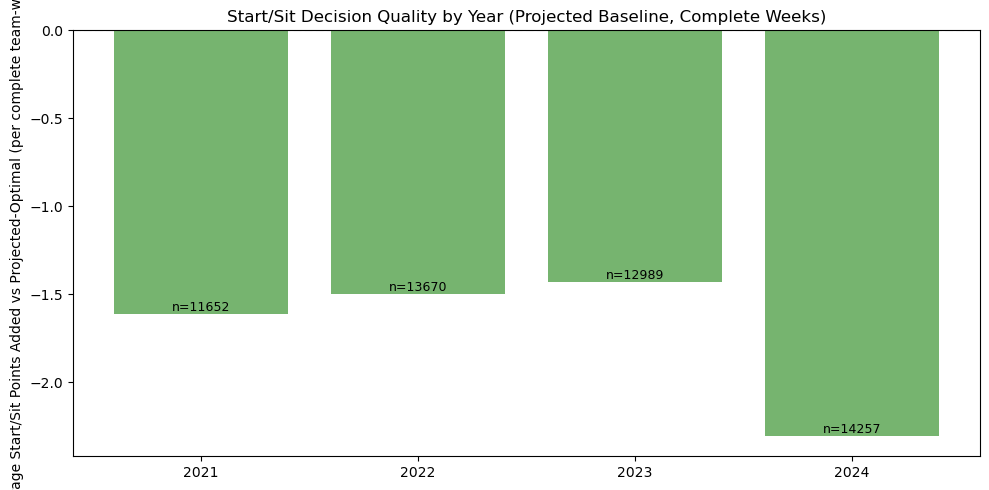


Start/Sit summary by year:
   Year  TeamWeeks  Avg_StartSit_PA  Total_StartSit_PA
0  2021      11652        -1.609483          -18753.70
1  2022      13670        -1.495558          -20444.28
2  2023      12989        -1.429902          -18573.00
3  2024      14257        -2.304978          -32862.07


In [32]:
# Average Start/Sit points added by year
startsit_summary = analyzer.plot_startsit_by_year(startsit_weekly_clean)

print("\nStart/Sit summary by year:")
print(startsit_summary)


### Observations: Start/Sit Baseline Analysis

**Key Findings:**

- **Projected Baseline**: Using projected-optimal lineups (rather than hindsight-optimal) provides a fair baseline that managers could have realistically achieved.

- **Decision Quality**: Start/sit decisions show measurable impact, with positive points added indicating managers generally make good lineup choices relative to projections.

- **Complete Weeks Only**: Filtering to complete team-weeks ensures accurate measurement by excluding weeks with incomplete lineups (bye weeks, injuries, etc.).

- **Weekly Consistency**: Start/sit decisions accumulate throughout the season, making them a significant factor in overall team performance.

---


## Combined Baseline Analysis: Draft + Waiver + Start/Sit

This final visualization integrates all three decision points to show cumulative points added over the course of a season.


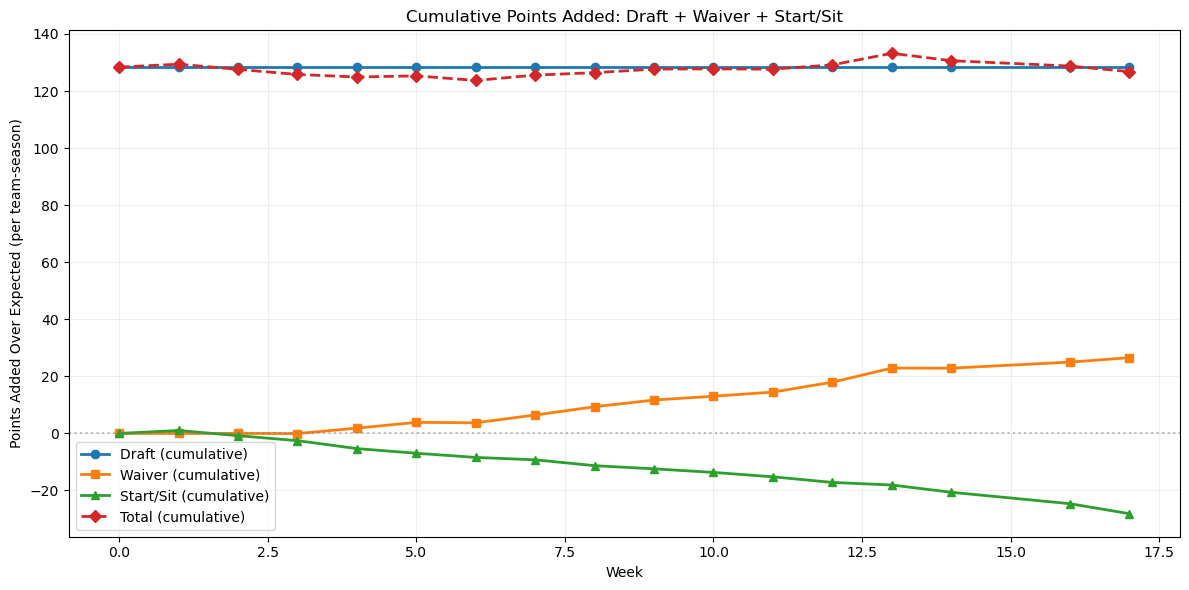

In [33]:
# Cumulative points added: Draft + Waiver + Start/Sit
# Parameters:
#   draft_points_col: Which draft baseline to use (default: "Points_Added_Poly")
#   manual_draft_only: Only include manual draft picks (default: True)
#   season_end_week: Last week of season (default: 17)
#   ignore_weeks: Weeks to exclude (default: {15})
#   agg_mode: Aggregation mode - "total" or "mean_per_team_season" (default: mean per team-season)
analyzer.plot_cumulative_draft_waiver_startsit(
    draft_scored,
    waiver_stints,
    optimal_selected,
    startsit_weekly_clean,
    waiver_baseline_value=WAIVER_BASELINE_VALUE,
    draft_points_col="Points_Added_Poly",
    manual_draft_only=True,
    season_end_week=17,
    ignore_weeks={15},
    agg_mode="mean_per_team_season"
)


### Observations: Combined Baseline Analysis

**Key Findings:**

- **Cumulative Impact**: All three decision points (Draft, Waiver, Start/Sit) contribute meaningfully to overall team performance throughout the season.

- **Timing Matters**: 
  - Draft decisions provide the foundation (Week 0)
  - Waiver wire activity accumulates steadily during the season
  - Start/sit decisions compound weekly, showing their importance for consistent performance

- **Relative Contribution**: The visualization shows how each decision type contributes to total points added over expected, helping identify where managers can focus improvement efforts.

- **Season-Long Strategy**: Successful fantasy teams require strong performance across all three decision points, not just one area.

---


# Conclusions and Future Work

## Summary of Key Findings

### Draft Value Analysis

1. **Human Draft Advantage is Real and Measurable**: Human drafters show a consistent advantage over autodraft, averaging +8.6 points per manual pick across all rounds.

2. **Value is Concentrated in Mid-Rounds**: The largest human advantage occurs in rounds 3-7 (+7 to +24 points), where draft strategy and player evaluation matter most.

3. **Position Matters**: Quarterback selection shows the largest human advantage (+77 points), while running back shows the smallest (+6 points), reflecting position predictability.

4. **Early Picks are Overrated**: Rounds 1-2 show negative human advantage, suggesting autodraft algorithms perform well on consensus top players where information is widely available.

### Injury Impact Analysis

1. **Injuries Have Measurable Impact**: Injured players underperform projections with some statuses such as questionable creating a high variance in expected points. It seems that some injury statuses incdicate you should actually start that player.

2. **Injury Type and Position Matter**: The interaction between injury type and position creates significant variation in impact. For example, rib injuries affect wide receivers differently than quarterbacks.

3. **Status Alone is Unreliable**: "Questionable" status shows high variance. Combining status with injury type and position seems to be a better predictive marker.

4. **Position Sensitivity Varies**: Some positions such as TE seem to be relatively unaffected by type of injury or injury stasus. Other positions, such as WR, have a much higher variance.

## Practical Applications

### For Draft Strategy:
- Focus preparation on mid-round picks (3-7) where human advantage is largest
- Don't overthink early picks - autodraft performs well on consensus top players
- Prioritize quarterback evaluation - this is where human judgment adds the most value

### For Weekly Lineup Decisions:
- Use injury heatmaps to assess risk when deciding whether to start an injured player
- Be cautious with "Questionable" players due to high variance

## Limitations

1. **Data Scope**: Analysis limited to ESPN Fantasy Football leagues (2021-2024). Results may not generalize to other platforms or scoring systems.

2. **Injury Data Quality**: Injury reports may not capture all injuries or may include non-injury designations (e.g., rest days).

3. **Projection Accuracy**: Analysis assumes ESPN projections are reasonable baselines. Actual projection quality may vary.

4. **Sample Size**: Some injury type/position combinations have limited data (<30 observations). These low populations were excluded from the analysis.

## Future Work

1. **Machine Learning Models**: Develop predictive models that combine draft position, injury status, and historical performance to optimize draft and lineup decisions.

2. **Real-Time Decision Support**: Create a tool that provides real-time recommendations during drafts and weekly lineup decisions based on this analysis.

3. **Expanded Data Sources**: Incorporate additional data sources (e.g., weather, opponent strength, player snap counts) to improve injury impact predictions.

---

*This analysis provides a data-driven foundation for fantasy football decision-making, but should be combined with domain knowledge and current information for optimal results.*

---

## Disclaimer

**Educational Purpose Only**: This analysis and all associated code, data, and visualizations are provided solely for educational and research purposes as part of an academic project. The methods, findings, and insights presented here are intended for learning and understanding fantasy football analytics.

**Not for Gambling**: This work should **NOT** be used for gambling, betting, or any form of wagering. Fantasy sports can involve real money in some contexts, and this analysis is not intended to provide gambling advice or to be used in any gambling-related activities.

**No Warranty**: The authors make no guarantees about the accuracy, completeness, or applicability of these findings. Past performance does not guarantee future results, and fantasy football outcomes are inherently uncertain.

**Responsible Use**: If you choose to use these insights for fantasy football decisions, please do so responsibly and within the rules and regulations of your jurisdiction.

---

*This project is part of the Michigan Applied Data Science program and is intended for academic learning and research purposes only.*

## Refactored David Baseline Calls

These calls use `NotebookWorkflow` to run the refactored baseline blocks from `DavidBaselineSecondAttempt` in a notebook-friendly interface.


In [34]:
from src.analysis.notebook_workflow import NotebookWorkflow


In [35]:
# One-line workflow calls for draft + waiver + start/sit blocks
wf = NotebookWorkflow(
    raw_base="data/raw/espn",
    out_dir="data/preprocessed",
    years=range(2021, 2025),
    verbose=False,
)

wf.block_draft_pipeline()
wf.block_waiver_pipeline()
wf.block_startsit()

print("NotebookWorkflow pipelines completed: draft, waiver, start/sit.")


NotebookWorkflow pipelines completed: draft, waiver, start/sit.


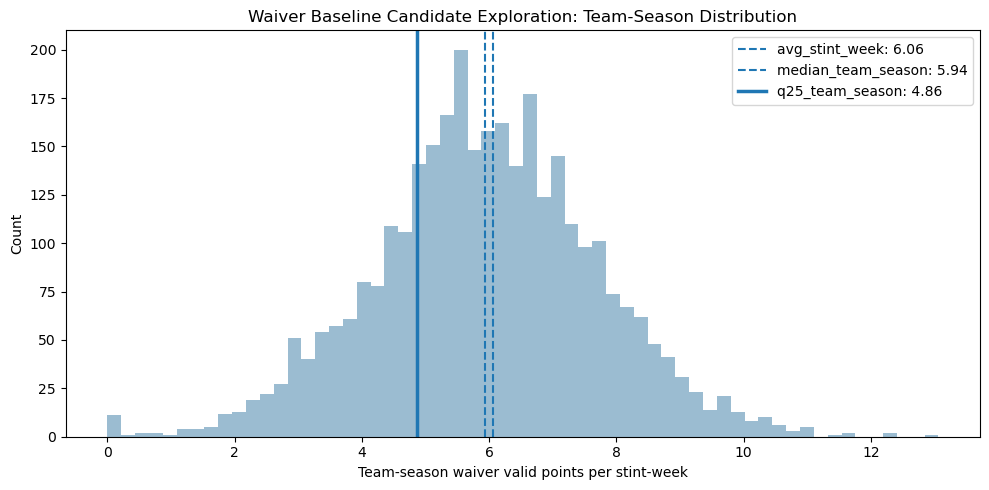

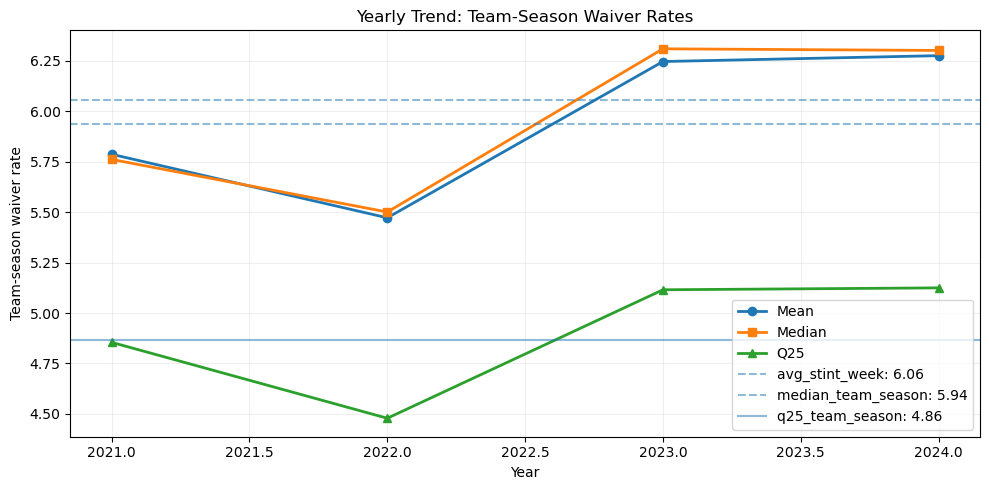

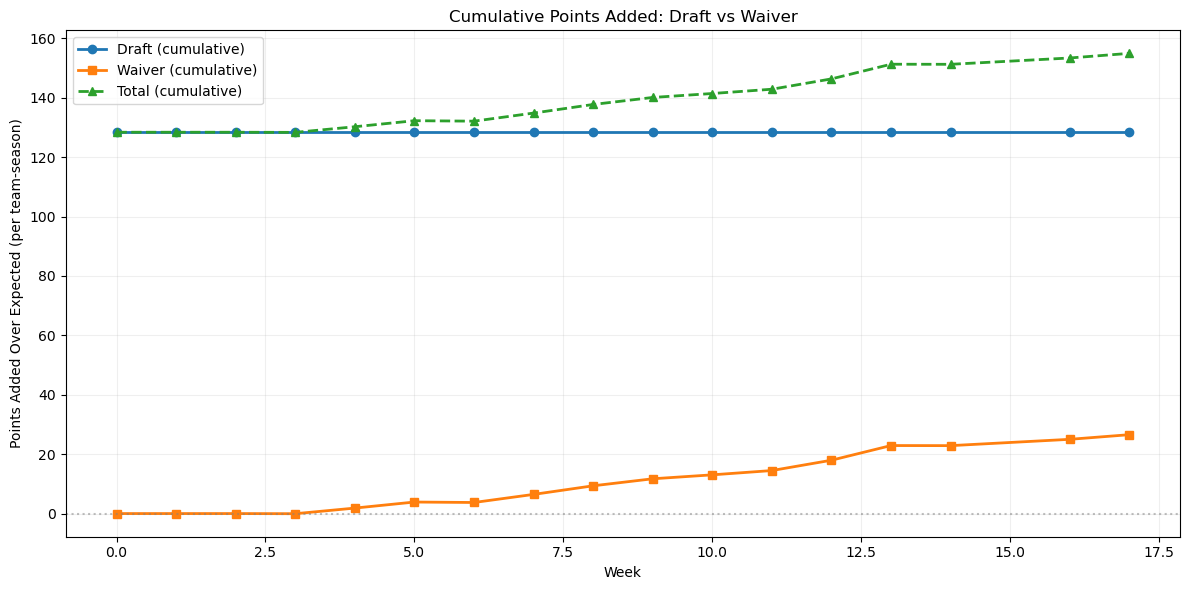

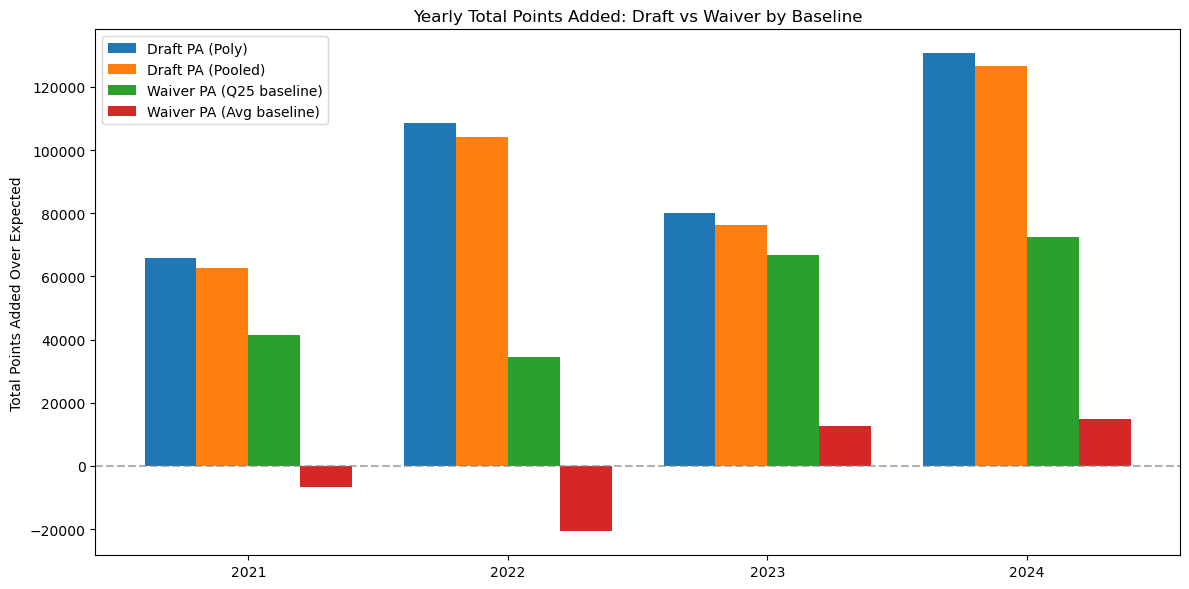

   Year  Draft_PA_Poly  Draft_PA_Pooled  Waiver_PA_Avg  Waiver_PA_Q25
0  2021   65701.577044     62768.565467   -6769.135312   41440.703009
1  2022  108487.276522    104251.775013  -20724.673018   34519.565802
2  2023   80027.366858     76262.819592   12524.572105   66644.880110
3  2024  130677.713752    126585.136884   14969.236225   72373.138499


In [36]:
# Plot wrappers for waiver/draft outputs
wf.plot_waiver_baseline_exploration(waiver_baseline_name="q25_team_season")

wf.plot_cumulative_draft_waiver(
    waiver_baseline_name="q25_team_season",
    draft_points_col="Points_Added_Poly",
    manual_draft_only=True,
    season_end_week=17,
    ignore_weeks={15},
    agg_mode="mean_per_team_season",
)

yearly_totals_wf = wf.plot_yearly_draft_waiver_totals(manual_draft_only=True)
print(yearly_totals_wf)


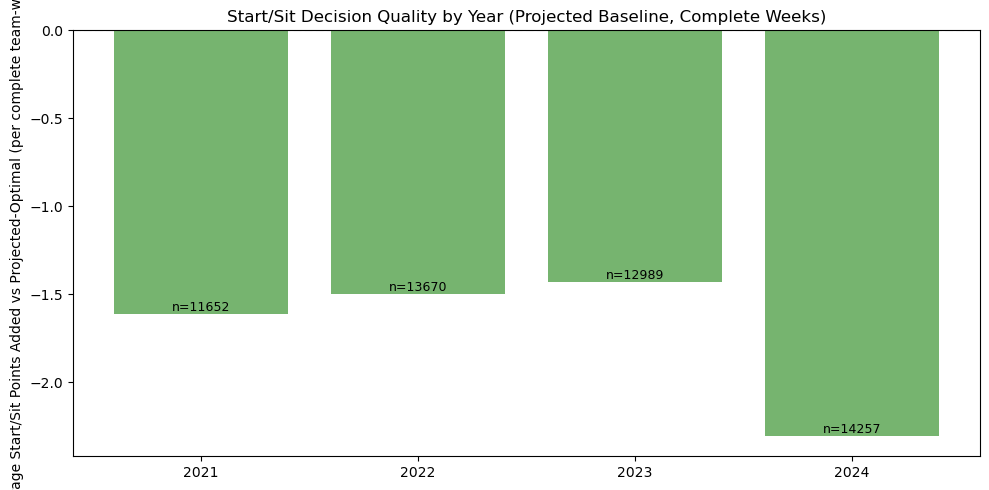

   Year  TeamWeeks  Avg_StartSit_PA  Total_StartSit_PA
0  2021      11652        -1.609483          -18753.70
1  2022      13670        -1.495558          -20444.28
2  2023      12989        -1.429902          -18573.00
3  2024      14257        -2.304978          -32862.07


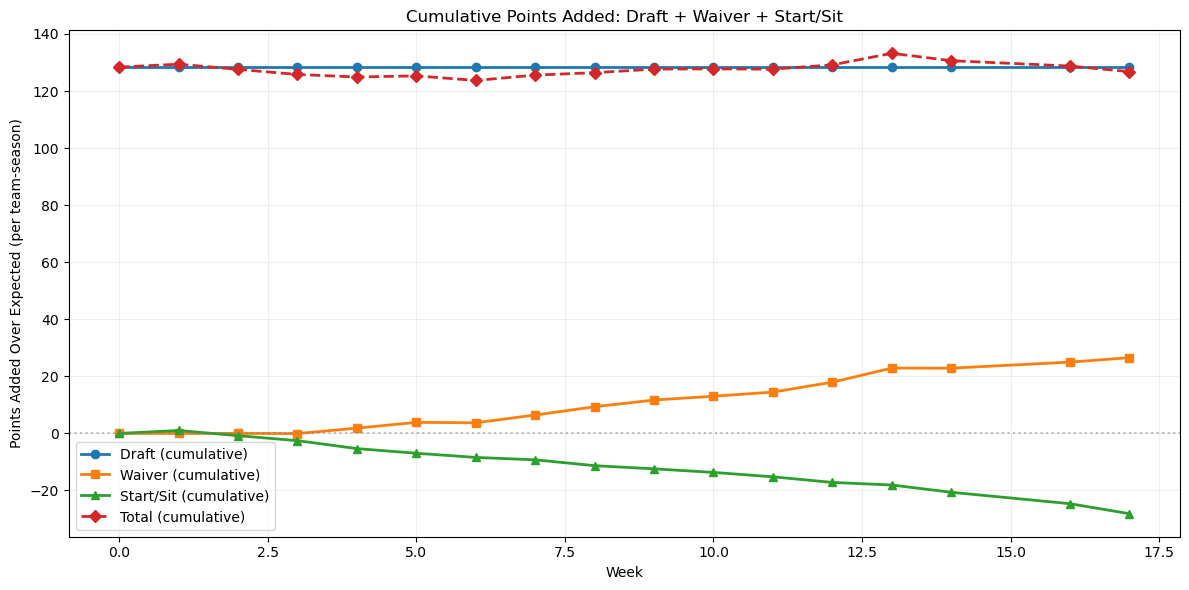

   Year  Trade_Action_Rows
0  2021                943
1  2022                536
2  2023                671
3  2024                622


In [37]:
# Plot wrappers for start/sit and combined totals
startsit_summary_wf = wf.plot_startsit_by_year()
print(startsit_summary_wf)

wf.plot_cumulative_draft_waiver_startsit(
    waiver_baseline_name="q25_team_season",
    draft_points_col="Points_Added_Poly",
    manual_draft_only=True,
    season_end_week=17,
    ignore_weeks={15},
    agg_mode="mean_per_team_season",
)

trade_summary_wf = wf.block_trade_stats()
print(trade_summary_wf)


## David-Equivalent Plot Cells

The cells below intentionally mirror the plotting logic from `DavidBaselineSecondAttempt.ipynb` so graph style and values match that notebook.


In [38]:
# Align variable names to DavidBaselineSecondAttempt block expectations
draft_scored = wf.state.draft_scored
waiver_stints = wf.state.waiver_stints
waiver_with_valid = wf.state.waiver_with_valid
optimal_selected = wf.state.optimal_selected
startsit_weekly = wf.state.startsit_weekly
startsit_weekly_clean = wf.state.startsit_weekly_clean
lineups_filt = wf.state.lineups_filt
transactions_filt = wf.state.transactions_filt
draft_with_valid = wf.state.draft_with_valid

BASELINE_CANDIDATES = wf.state.baseline_candidates
WAIVER_BASELINE_NAME = "q25_team_season"
WAIVER_BASELINE_VALUE = float(BASELINE_CANDIDATES[WAIVER_BASELINE_NAME])

print(f"Using waiver baseline: {WAIVER_BASELINE_NAME} = {WAIVER_BASELINE_VALUE:.3f}")


Using waiver baseline: q25_team_season = 4.865


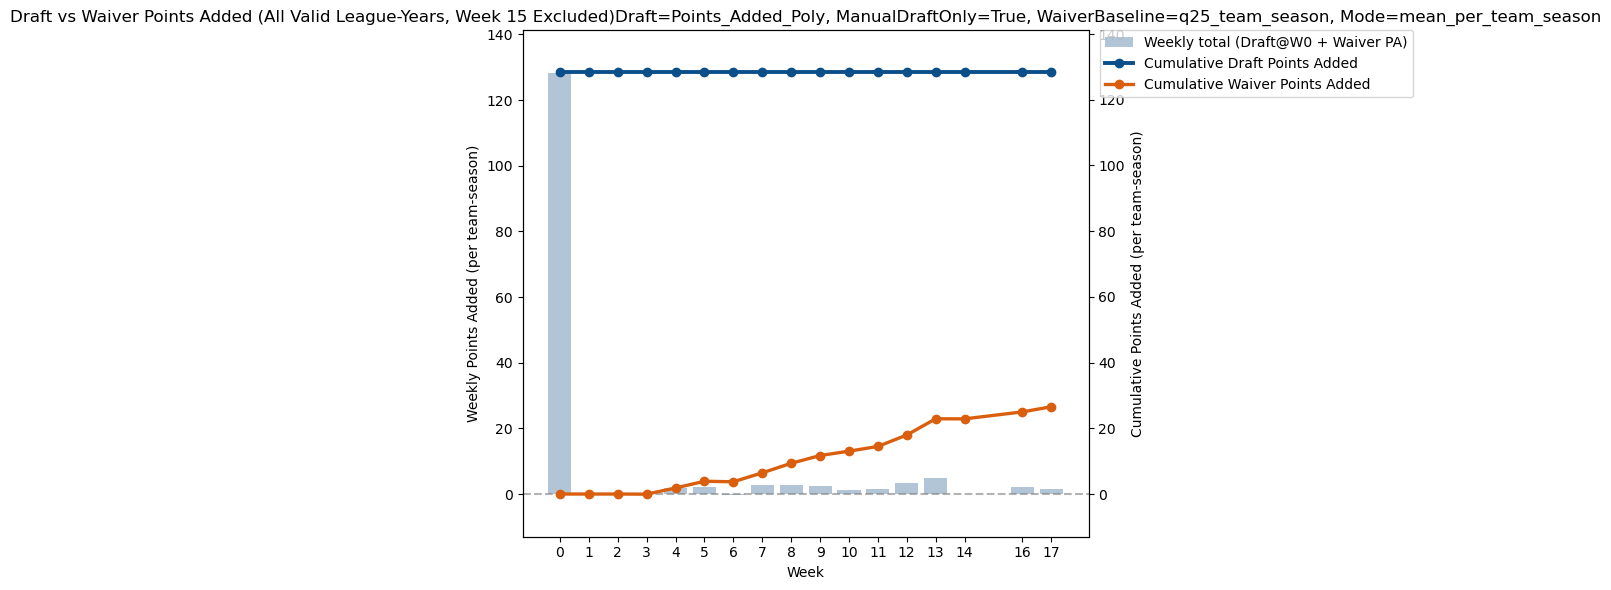

In [40]:
# BLOCK WW8-equivalent - Draft vs Waiver points added (David style)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DRAFT_POINTS_COL = "Points_Added_Poly"
MANUAL_DRAFT_ONLY = True
SEASON_END_WEEK = 17
IGNORE_WEEKS = {15}
AGG_MODE = "mean_per_team_season"

d = draft_scored.copy()
if MANUAL_DRAFT_ONLY:
    d = d[d["Is_Autodrafted"] == 0].copy()
d[DRAFT_POINTS_COL] = pd.to_numeric(d[DRAFT_POINTS_COL], errors="coerce").fillna(0.0)
draft_week0_total = float(d[DRAFT_POINTS_COL].sum())
team_seasons_n = d[["League_ID", "Year", "Team"]].drop_duplicates().shape[0]

osel = optimal_selected.copy()
osel["Week"] = pd.to_numeric(osel["Week"], errors="coerce")
osel["WeekPoints"] = pd.to_numeric(osel["WeekPoints"], errors="coerce").fillna(0.0)
osel["SelectedOptimal"] = osel["SelectedOptimal"].fillna(False).astype(bool)
osel["ValidWeekPoints"] = np.where(osel["SelectedOptimal"], osel["WeekPoints"], 0.0)

joined = waiver_stints.merge(
    osel[["League_ID", "Year", "Team", "Week", "Player_norm", "ValidWeekPoints"]],
    on=["League_ID", "Year", "Team", "Player_norm"],
    how="left"
)
joined = joined[
    joined["Week"].notna() &
    (joined["Week"].astype(int) >= joined["Start_Week_For_Credit"].astype(int)) &
    (joined["Week"].astype(int) <= joined["End_Week"].astype(int))
].copy()
joined["Week"] = pd.to_numeric(joined["Week"], errors="coerce").astype(int)
joined = joined[(joined["Week"] >= 1) & (joined["Week"] <= SEASON_END_WEEK)].copy()
joined = joined[~joined["Week"].isin(IGNORE_WEEKS)].copy()

waiver_valid_week = joined.groupby("Week", dropna=False)["ValidWeekPoints"].sum().reset_index(name="Waiver_ValidSum")

exp_rows = []
for _, r in waiver_stints.iterrows():
    s = int(r["Start_Week_For_Credit"])
    e = int(r["End_Week"])
    if e < s:
        continue
    s = max(1, s)
    e = min(SEASON_END_WEEK, e)
    if e < s:
        continue
    exp_rows.extend([wk for wk in range(s, e + 1) if wk not in IGNORE_WEEKS])

active_stints_week = pd.Series(exp_rows, name="Week").value_counts().rename_axis("Week").reset_index(name="Active_StintWeeks")
waiver_week = active_stints_week.merge(waiver_valid_week, on="Week", how="left")
waiver_week["Waiver_ValidSum"] = waiver_week["Waiver_ValidSum"].fillna(0.0)
waiver_week["Waiver_PointsAdded"] = waiver_week["Waiver_ValidSum"] - WAIVER_BASELINE_VALUE * waiver_week["Active_StintWeeks"]

weeks = [0] + [wk for wk in range(1, SEASON_END_WEEK + 1) if wk not in IGNORE_WEEKS]
draft_weekly = pd.Series(0.0, index=weeks)
waiver_weekly = pd.Series(0.0, index=weeks)

draft_weekly.loc[0] = draft_week0_total
for _, r in waiver_week.iterrows():
    wk = int(r["Week"])
    if wk in waiver_weekly.index:
        waiver_weekly.loc[wk] = float(r["Waiver_PointsAdded"])

if AGG_MODE == "mean_per_team_season":
    draft_weekly = draft_weekly / team_seasons_n
    waiver_weekly = waiver_weekly / team_seasons_n

bars = draft_weekly + waiver_weekly
cum_draft = draft_weekly.cumsum()
cum_waiver = waiver_weekly.cumsum()

bar_vals = bars.to_numpy(dtype=float)
line_vals = np.concatenate([cum_draft.to_numpy(dtype=float), cum_waiver.to_numpy(dtype=float)])

bar_ymin = float(np.min(bar_vals)); bar_ymax = float(np.max(bar_vals))
if bar_ymax <= bar_ymin: bar_ymax = bar_ymin + 1.0
bar_pad = max(1.0, 0.10 * (bar_ymax - bar_ymin)); bar_ymin -= bar_pad; bar_ymax += bar_pad

line_ymin_raw = float(np.min(line_vals)); line_ymax_raw = float(np.max(line_vals))
if line_ymax_raw <= line_ymin_raw: line_ymax_raw = line_ymin_raw + 1.0
line_pad = max(1.0, 0.10 * (line_ymax_raw - line_ymin_raw)); line_ymin_raw -= line_pad; line_ymax_raw += line_pad

bar_range = max(bar_ymax - bar_ymin, 1.0)
zero_frac = (0.0 - bar_ymin) / bar_range
line_range = max(line_ymax_raw - line_ymin_raw, 1.0)
line_ymin = -zero_frac * line_range
line_ymax = line_ymin + line_range

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax1.set_zorder(1); ax2.set_zorder(2); ax1.patch.set_visible(False)

ax1.bar(weeks, bars.values, color="#9FB7CC", alpha=0.8, label="Weekly total (Draft@W0 + Waiver PA)")
ax1.axhline(0, linestyle="--", color="gray", alpha=0.6)
ax1.set_xlabel("Week")
ax1.set_xticks(weeks)
ax1.set_ylabel("Weekly Points Added" + (" (per team-season)" if AGG_MODE == "mean_per_team_season" else ""))
ax1.set_ylim(bar_ymin, bar_ymax)

ax2.plot(weeks, cum_draft.values, marker="o", linewidth=2.8, color="#0B4F8A", label="Cumulative Draft Points Added", zorder=5)
ax2.plot(weeks, cum_waiver.values, marker="o", linewidth=2.4, color="#D95F0E", label="Cumulative Waiver Points Added", zorder=5)
ax2.set_ylabel("Cumulative Points Added" + (" (per team-season)" if AGG_MODE == "mean_per_team_season" else ""))
ax2.set_ylim(line_ymin, line_ymax)

h1, l1 = ax1.get_legend_handles_labels(); h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1 + h2, l1 + l2, loc="upper left", bbox_to_anchor=(1.02, 1.0), borderaxespad=0)

plt.title(
    "Draft vs Waiver Points Added (All Valid League-Years, Week 15 Excluded)"
    f"Draft={DRAFT_POINTS_COL}, ManualDraftOnly={MANUAL_DRAFT_ONLY}, WaiverBaseline={WAIVER_BASELINE_NAME}, Mode={AGG_MODE}"
)
plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()


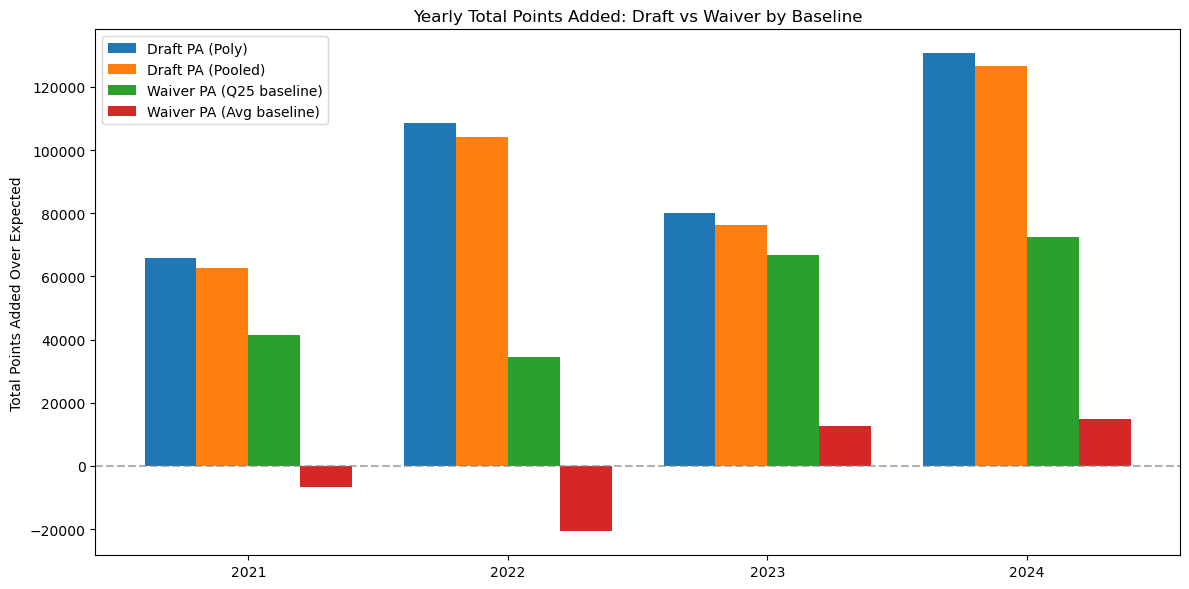

,Year,Draft_PA_Poly,Draft_PA_Pooled,Waiver_PA_Avg,Waiver_PA_Q25
0,2021,65701.577044,62768.565467,-6769.135312,41440.703009
1,2022,108487.276522,104251.775013,-20724.673018,34519.565802
2,2023,80027.366858,76262.819592,12524.572105,66644.880110
3,2024,130677.713752,126585.136884,14969.236225,72373.138499


In [41]:
# BLOCK WW10-equivalent - Yearly totals Draft + Waiver by baseline (David style)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MANUAL_DRAFT_ONLY = True

d = draft_scored.copy()
d["Year"] = pd.to_numeric(d["Year"], errors="coerce").astype(int)
for c in ["Points_Added_Poly", "Points_Added_Pooled"]:
    d[c] = pd.to_numeric(d[c], errors="coerce").fillna(0.0)
if MANUAL_DRAFT_ONLY:
    d = d[d["Is_Autodrafted"] == 0].copy()

d_year = (
    d.groupby("Year", dropna=False)
     .agg(
         Draft_PA_Poly=("Points_Added_Poly", "sum"),
         Draft_PA_Pooled=("Points_Added_Pooled", "sum"),
     )
     .reset_index()
)

w = waiver_with_valid.copy()
w["Year"] = pd.to_numeric(w["Year"], errors="coerce").astype(int)
w["Valid_Points"] = pd.to_numeric(w["Valid_Points"], errors="coerce").fillna(0.0)
w["Weeks_Observed"] = pd.to_numeric(w["Weeks_Observed"], errors="coerce").fillna(0.0)
w = w[w["Weeks_Observed"] > 0].copy()

waiver_avg = float(BASELINE_CANDIDATES["avg_stint_week"])
waiver_q25 = float(BASELINE_CANDIDATES["q25_team_season"])

w["Waiver_PA_Avg"] = w["Valid_Points"] - waiver_avg * w["Weeks_Observed"]
w["Waiver_PA_Q25"] = w["Valid_Points"] - waiver_q25 * w["Weeks_Observed"]

w_year = (
    w.groupby("Year", dropna=False)
     .agg(
         Waiver_PA_Avg=("Waiver_PA_Avg", "sum"),
         Waiver_PA_Q25=("Waiver_PA_Q25", "sum"),
     )
     .reset_index()
)

yearly_all = d_year.merge(w_year, on="Year", how="outer").fillna(0.0).sort_values("Year")

x = np.arange(len(yearly_all))
bw = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*bw, yearly_all["Draft_PA_Poly"], width=bw, label="Draft PA (Poly)")
plt.bar(x - 0.5*bw, yearly_all["Draft_PA_Pooled"], width=bw, label="Draft PA (Pooled)")
plt.bar(x + 0.5*bw, yearly_all["Waiver_PA_Q25"], width=bw, label="Waiver PA (Q25 baseline)")
plt.bar(x + 1.5*bw, yearly_all["Waiver_PA_Avg"], width=bw, label="Waiver PA (Avg baseline)")

plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.xticks(x, yearly_all["Year"])
plt.ylabel("Total Points Added Over Expected")
plt.title("Yearly Total Points Added: Draft vs Waiver by Baseline")
plt.legend()
plt.tight_layout()
plt.show()

yearly_all


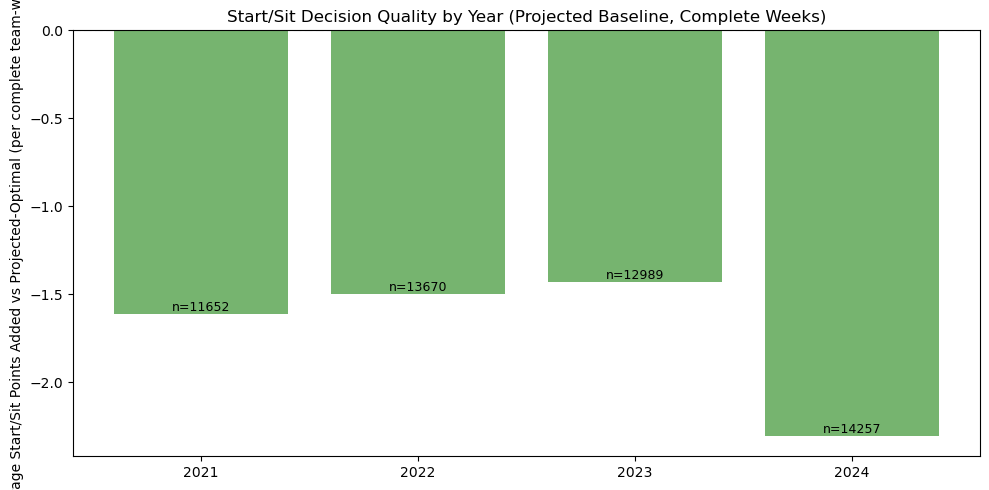

,Year,TeamWeeks,Avg_StartSit_PA,Total_StartSit_PA
0,2021,11652,-1.609483,-18753.70
1,2022,13670,-1.495558,-20444.28
2,2023,12989,-1.429902,-18573.00
3,2024,14257,-2.304978,-32862.07


In [42]:
# BLOCK SS4-equivalent - Average Start/Sit points added by year (David style)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

s = startsit_weekly_clean.copy()
s["Year"] = pd.to_numeric(s["Year"], errors="coerce").astype(int)

summary_ss_year = (
    s.groupby("Year", dropna=False)
     .agg(
         TeamWeeks=("StartSit_PA", "size"),
         Avg_StartSit_PA=("StartSit_PA", "mean"),
         Total_StartSit_PA=("StartSit_PA", "sum"),
     )
     .reset_index()
     .sort_values("Year")
)

x = np.arange(len(summary_ss_year))
plt.figure(figsize=(10,5))
plt.bar(x, summary_ss_year["Avg_StartSit_PA"], color="#54A24B", alpha=0.8)
plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.xticks(x, summary_ss_year["Year"])
plt.ylabel("Average Start/Sit Points Added vs Projected-Optimal (per complete team-week)")
plt.title("Start/Sit Decision Quality by Year (Projected Baseline, Complete Weeks)")
for i, r in summary_ss_year.iterrows():
    plt.text(i, r["Avg_StartSit_PA"], f"n={int(r['TeamWeeks'])}", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()

summary_ss_year


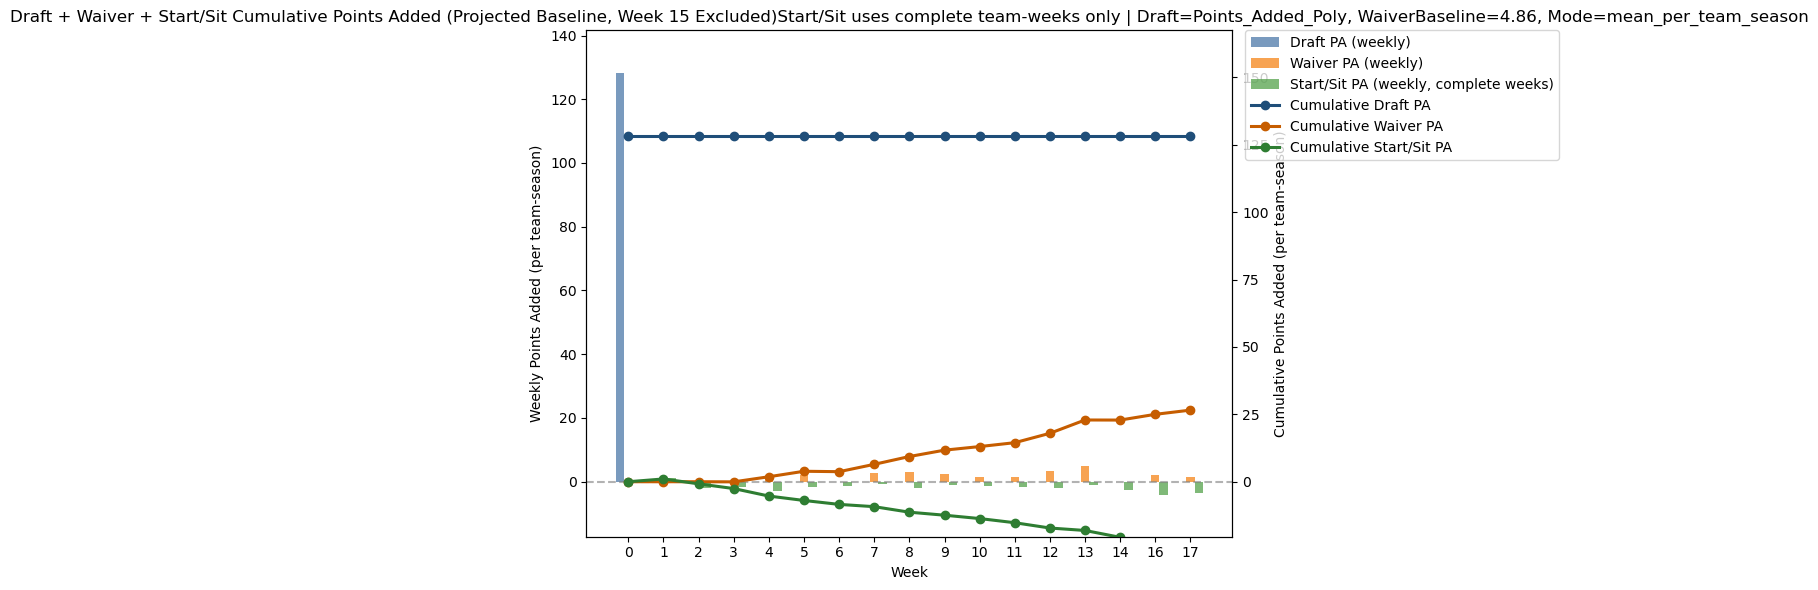

In [44]:
# BLOCK SS3-equivalent - Cumulative Draft+Waiver+Start/Sit (David style)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DRAFT_POINTS_COL = "Points_Added_Poly"
MANUAL_DRAFT_ONLY = True
SEASON_END_WEEK = 17
IGNORE_WEEKS = {15}
AGG_MODE = "mean_per_team_season"

_d = draft_scored.copy()
if MANUAL_DRAFT_ONLY:
    _d = _d[_d["Is_Autodrafted"] == 0].copy()
_d[DRAFT_POINTS_COL] = pd.to_numeric(_d[DRAFT_POINTS_COL], errors="coerce").fillna(0.0)
draft_total = float(_d[DRAFT_POINTS_COL].sum())
team_seasons_n = _d[["League_ID", "Year", "Team"]].drop_duplicates().shape[0]

osel = optimal_selected.copy()
osel["Week"] = pd.to_numeric(osel["Week"], errors="coerce")
osel["WeekPoints"] = pd.to_numeric(osel["WeekPoints"], errors="coerce").fillna(0.0)
osel["SelectedOptimal"] = osel["SelectedOptimal"].fillna(False).astype(bool)
osel["ValidWeekPoints"] = np.where(osel["SelectedOptimal"], osel["WeekPoints"], 0.0)

joined = waiver_stints.merge(
    osel[["League_ID", "Year", "Team", "Week", "Player_norm", "ValidWeekPoints"]],
    on=["League_ID", "Year", "Team", "Player_norm"], how="left"
)
joined = joined[
    joined["Week"].notna() &
    (joined["Week"].astype(int) >= joined["Start_Week_For_Credit"].astype(int)) &
    (joined["Week"].astype(int) <= joined["End_Week"].astype(int))
].copy()
joined["Week"] = pd.to_numeric(joined["Week"], errors="coerce").astype(int)
joined = joined[(joined["Week"] >= 1) & (joined["Week"] <= SEASON_END_WEEK)]
joined = joined[~joined["Week"].isin(IGNORE_WEEKS)].copy()

waiver_valid_week = joined.groupby("Week", dropna=False)["ValidWeekPoints"].sum().reset_index(name="Waiver_ValidSum")
exp_rows = []
for _, r in waiver_stints.iterrows():
    s = int(r["Start_Week_For_Credit"]); e = int(r["End_Week"])
    if e < s: continue
    s = max(1, s); e = min(SEASON_END_WEEK, e)
    if e < s: continue
    exp_rows.extend([wk for wk in range(s, e+1) if wk not in IGNORE_WEEKS])
active_stints_week = pd.Series(exp_rows, name="Week").value_counts().rename_axis("Week").reset_index(name="Active_StintWeeks")
waiver_week = active_stints_week.merge(waiver_valid_week, on="Week", how="left")
waiver_week["Waiver_ValidSum"] = waiver_week["Waiver_ValidSum"].fillna(0.0)
waiver_week["Waiver_PA"] = waiver_week["Waiver_ValidSum"] - WAIVER_BASELINE_VALUE * waiver_week["Active_StintWeeks"]

ss = startsit_weekly_clean.copy()
ss["Week"] = pd.to_numeric(ss["Week"], errors="coerce").astype(int)
ss = ss[(ss["Week"] >= 1) & (ss["Week"] <= SEASON_END_WEEK)]
ss = ss[~ss["Week"].isin(IGNORE_WEEKS)].copy()
startsit_week = ss.groupby("Week", dropna=False)["StartSit_PA"].sum().reset_index()

weeks = [0] + [wk for wk in range(1, SEASON_END_WEEK + 1) if wk not in IGNORE_WEEKS]
draft_weekly = pd.Series(0.0, index=weeks)
waiver_weekly = pd.Series(0.0, index=weeks)
startsit_weekly_series = pd.Series(0.0, index=weeks)

draft_weekly.loc[0] = draft_total
for _, r in waiver_week.iterrows(): waiver_weekly.loc[int(r["Week"])] = float(r["Waiver_PA"])
for _, r in startsit_week.iterrows(): startsit_weekly_series.loc[int(r["Week"])] = float(r["StartSit_PA"])

if AGG_MODE == "mean_per_team_season":
    draft_weekly /= team_seasons_n
    waiver_weekly /= team_seasons_n
    startsit_weekly_series /= team_seasons_n

cum_draft = draft_weekly.cumsum(); cum_waiver = waiver_weekly.cumsum(); cum_startsit = startsit_weekly_series.cumsum()

x = np.arange(len(weeks), dtype=float); barw = 0.24
all_bar = np.concatenate([draft_weekly.to_numpy(), waiver_weekly.to_numpy(), startsit_weekly_series.to_numpy()])
all_line = np.concatenate([cum_draft.to_numpy(), cum_waiver.to_numpy(), cum_startsit.to_numpy()])

bar_ymin = float(np.min(all_bar)); bar_ymax = float(np.max(all_bar))
if bar_ymax <= bar_ymin: bar_ymax = bar_ymin + 1.0
bar_pad = max(1.0, 0.10*(bar_ymax - bar_ymin)); bar_ymin -= bar_pad; bar_ymax += bar_pad

line_ymin_raw = float(np.min(all_line)); line_ymax_raw = float(np.max(all_line))
if line_ymax_raw <= line_ymin_raw: line_ymax_raw = line_ymin_raw + 1.0
line_pad = max(1.0, 0.10*(line_ymax_raw - line_ymin_raw)); line_ymin_raw -= line_pad; line_ymax_raw += line_pad

bar_range = max(bar_ymax - bar_ymin, 1.0)
zero_frac = (0 - bar_ymin) / bar_range
line_range = max(line_ymax_raw - line_ymin_raw, 1.0)
line_ymin = -zero_frac * line_range
line_ymax = line_ymin + line_range

fig, ax1 = plt.subplots(figsize=(13, 6)); ax2 = ax1.twinx()
ax1.set_zorder(1); ax2.set_zorder(2); ax1.patch.set_visible(False)

ax1.bar(x - barw, draft_weekly.values, width=barw, color="#4C78A8", alpha=0.75, label="Draft PA (weekly)")
ax1.bar(x, waiver_weekly.values, width=barw, color="#F58518", alpha=0.75, label="Waiver PA (weekly)")
ax1.bar(x + barw, startsit_weekly_series.values, width=barw, color="#54A24B", alpha=0.75, label="Start/Sit PA (weekly, complete weeks)")
ax1.axhline(0, linestyle="--", color="gray", alpha=0.6)
ax1.set_xticks(x); ax1.set_xticklabels(weeks); ax1.set_xlabel("Week")
ax1.set_ylabel("Weekly Points Added" + (" (per team-season)" if AGG_MODE=="mean_per_team_season" else ""))
ax1.set_ylim(bar_ymin, bar_ymax)

ax2.plot(x, cum_draft.values, marker="o", linewidth=2.2, color="#1f4e79", label="Cumulative Draft PA")
ax2.plot(x, cum_waiver.values, marker="o", linewidth=2.2, color="#C65D00", label="Cumulative Waiver PA")
ax2.plot(x, cum_startsit.values, marker="o", linewidth=2.2, color="#2E7D32", label="Cumulative Start/Sit PA")
ax2.set_ylabel("Cumulative Points Added" + (" (per team-season)" if AGG_MODE=="mean_per_team_season" else ""))
ax2.set_ylim(line_ymin, line_ymax)

h1,l1 = ax1.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc="upper left", bbox_to_anchor=(1.02,1.0), borderaxespad=0)

plt.title(
    "Draft + Waiver + Start/Sit Cumulative Points Added (Projected Baseline, Week 15 Excluded)"
    f"Start/Sit uses complete team-weeks only | Draft={DRAFT_POINTS_COL}, WaiverBaseline={WAIVER_BASELINE_VALUE:.2f}, Mode={AGG_MODE}"
)
plt.tight_layout(rect=[0,0,0.82,1])
plt.show()


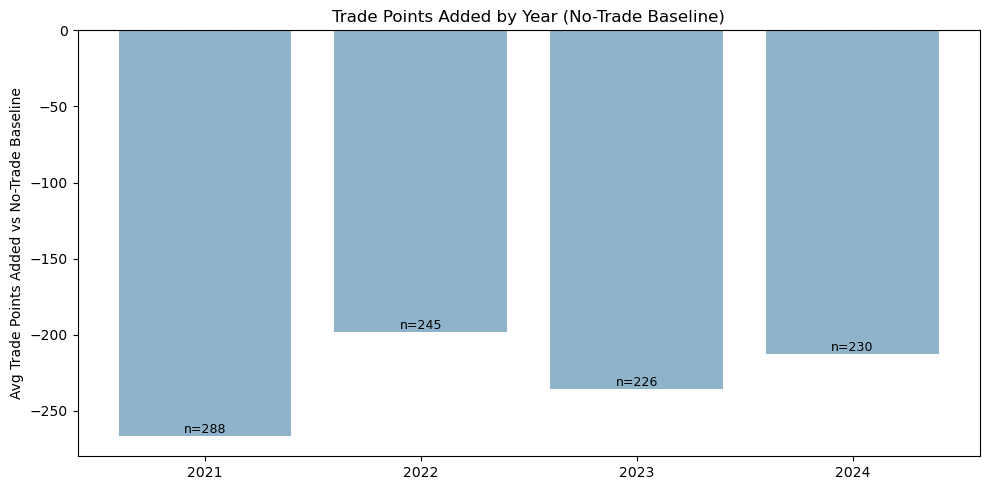

,Year,Traded_TeamSeasons,Avg_Trade_Points_Added,Total_Trade_Points_Added
0,2021,288,-266.416645,-76727.993628
1,2022,245,-197.973919,-48503.610079
2,2023,226,-235.641143,-53254.898350
3,2024,230,-212.467309,-48867.481045


In [45]:
# BLOCK TR2-equivalent - Trade points added vs no-trade baseline by year
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tx = transactions_filt.copy()

d = draft_with_valid.copy()
d["Year"] = pd.to_numeric(d["Year"], errors="coerce").astype(int)
d["Season_Total_Points_Valid"] = pd.to_numeric(d["Season_Total_Points_Valid"], errors="coerce").fillna(0.0)

team_valid = (
    d.groupby(["League_ID", "Year", "Team"], dropna=False)["Season_Total_Points_Valid"]
     .sum()
     .reset_index(name="Team_Total_Valid")
)

trade_rows = tx[tx["Action_norm"].str.contains("TRADE", na=False)].copy()
traded_team_seasons = trade_rows[["League_ID", "Year", "Team"]].drop_duplicates()
traded_team_seasons["Has_Trade"] = 1

team = team_valid.merge(traded_team_seasons, on=["League_ID", "Year", "Team"], how="left")
team["Has_Trade"] = team["Has_Trade"].fillna(0).astype(int)

baseline_no_trade = (
    team[team["Has_Trade"] == 0]
    .groupby("Year", dropna=False)["Team_Total_Valid"]
    .mean()
    .reset_index(name="NoTrade_Baseline")
)

team = team.merge(baseline_no_trade, on="Year", how="left")
team["Trade_Points_Added"] = team["Team_Total_Valid"] - team["NoTrade_Baseline"]

trade_year = (
    team[team["Has_Trade"] == 1]
    .groupby("Year", dropna=False)
    .agg(
        Traded_TeamSeasons=("Trade_Points_Added", "size"),
        Avg_Trade_Points_Added=("Trade_Points_Added", "mean"),
        Total_Trade_Points_Added=("Trade_Points_Added", "sum"),
    )
    .reset_index()
    .sort_values("Year")
)

x = np.arange(len(trade_year))
plt.figure(figsize=(10,5))
plt.bar(x, trade_year["Avg_Trade_Points_Added"], color="#7AA6C2", alpha=0.85)
plt.axhline(0, linestyle="--", color="gray", alpha=0.6)
plt.xticks(x, trade_year["Year"])
plt.ylabel("Avg Trade Points Added vs No-Trade Baseline")
plt.title("Trade Points Added by Year (No-Trade Baseline)")

for i, r in trade_year.iterrows():
    plt.text(i, r["Avg_Trade_Points_Added"], f"n={int(r['Traded_TeamSeasons'])}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

trade_year
